<a href="https://colab.research.google.com/github/Andreaierardi/sentiment-puccini/blob/main/notebook/sentiment_Puccini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Puccini by mail**

<br>
<br>

## Project description

In 2024 will be the centenary of the death of Giacomo Puccini, one of the greatest authors of Casa Ricordi.
The great interest of Puccini is not only linked to his universal notoriety nor to the constant and still current success of his works, but also to his language, rich in Tuscanisms and inventions. The letters of Puccini can be studied from the perspective of sentiment analysis in order to link the text to several aspects of the temperament of Puccini, the moments of depression and discouragement from which he suffered periodically, his insecurity about his own abilities, certain difficulties in the relationship with his librettists.

The Ricordi Archive keeps 381 letters written by Puccini to various recipients of Casa Ricordi, and 1387 letters sent to him by the publishing house. To these are added another 120/130 letters present in the database but not kept in the archive. In total, therefore, it is about 2000 letters to be analyzed.

The project aims at studying the letters with aspect based sentiment analysis techniques in order to extract not only the general sentiment polarity but also specific aspects and opinions that may be associated with the events of the life of Giacomo Puccini.

### Dataset
Provided by the Ricordi Archive [link](https://www.digitalarchivioricordi.com/it/people/display/2/Giacomo%20Puccini)

Evalita 2016 Sentipolc [link](http://www.di.unito.it/~tutreeb/sentipolc-evalita16/index.html)


<br>
<br>

---



<br>
<br>

# Data Retrieval

<br>

In [1]:
from os import path
from wordcloud import WordCloud

ModuleNotFoundError: No module named 'wordcloud'

In [2]:
import requests
import lxml.html as lh
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
url='https://www.digitalarchivioricordi.com/it/people/display/2/Giacomo%20Puccini?show=100&page='


In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stopwords.words('italian')

In [ ]:
from bs4 import BeautifulSoup

all_letters_name = []
dfs = pd.DataFrame(["ciao"])

page_num = 0
while len(dfs)> 0:
  page_num += 1
  page = requests.get(url+str(page_num))
  soup = BeautifulSoup(page.text, 'html.parser')

  dfs = pd.read_html(page.text)
  dfs = dfs[0]

  fixed_names_list = dfs['Segnatura'].str.replace(r' >', '').to_list()
  all_letters_name += fixed_names_list
  

In [ ]:
all_letters_name[:10]

['LLET006891',
 'LLET011812',
 'LLET006894',
 'LLET006895',
 'LLET006896',
 'LLET011820',
 'LLET007441',
 'LLET007443',
 'LLET007444',
 'LLET007442']

 **It is not possible to use page response because the page return always a page with empty tables**




In [ ]:
len(all_letters_name)

500

In [ ]:
generic_letter_url = 'https://www.digitalarchivioricordi.com/it/letter/display/'

In [ ]:
import time 
import re
import numpy as np


start_time = time.time()

letters_dict = {}

text_list = []
no_empty_letters = []
for letter_name in all_letters_name:
  letter_url =generic_letter_url+letter_name
  #print(letter_name)
  page = requests.get(letter_url)
  soup = BeautifulSoup(page.text, 'html.parser')
  text_html = soup.find_all('div',{'class':'transcription-text'})
  raw_text= text_html[0].get_text()
  
  if 'letters@archivioricordi.com' in raw_text:
    continue
  nospace_text = raw_text.replace("  ", "")
  letters_dict[letter_name]= dict()
  letters_dict[letter_name]['id'] = letter_name
  letters_dict[letter_name]['text'] = nospace_text

  titles = soup.find_all('div',{'id':'letter-info-top'})
  titles = titles[0]

  titles2 = soup.find_all('div',{'id':'letter-date-place'}) 
  titles2 = titles2[0]
  emit  = np.nan if re.sub('[^A-Za-z0-9]+', ' ', titles.find_all('h4')[0].get_text()).strip() == ''  else re.sub('[^A-Za-z0-9]+', ' ', titles.find_all('h4')[0].get_text()).strip()
  rec = np.nan if re.sub('[^A-Za-z0-9]+', ' ', titles.find_all('h5')[0].get_text()).strip() == ''  else re.sub('[^A-Za-z0-9]+', ' ', titles.find_all('h5')[0].get_text()).strip()
  #titles.find_all('h5')[0].get_text()
  date = titles2.find_all('b')[0].get_text().strip()
  place =titles2.find_all('b')[1].get_text()
  
  letters_dict[letter_name]['emit'] = emit
  letters_dict[letter_name]['rec'] = rec
  letters_dict[letter_name]['date'] = date
  letters_dict[letter_name]['place'] = place

  text_html = soup.find_all('div',{'id':'letter-show-details'})
  stringify  = text_html[0].get_text().split('Lettera titolo')
  other_info = re.sub('[^A-Za-z0-9-\n-\.]+', ' ', stringify[1]).strip().split('\n')
  other_info  = [el for el in other_info if el !='']
  #print(other_info)
  #letters_dict[letter_name]['title_letter'] = other_info[0]
  for index_str in range(1,len(other_info)):
    if "SFOGLIA" not in other_info[index_str]:
      key = ' '.join(other_info[index_str].split(' ')[0:-1]).strip().replace(" ", "_").lower()
      key = re.sub('[^A-Za-z0-9-\_]+', '',key.strip())
      val = other_info[index_str].split(' ')[-1]
      letters_dict[letter_name][key] = val

  divs_metadata = ['letter-show-details-named-people','letter-show-details-named-works','letter-show-details-named-places','letter-show-details-named-teatri','letter-show-details-tipologia','letter-show-details-sottotipologia','letter-show-details-scrittura','letter-show-details-linuga',
                   #'letter-show-details-metadati-fisici'
                   ]

  metadata_dict = {}
  for div in divs_metadata:
    name_key = div.split('letter-show-details-')[1].replace("-","_")

    metadata = soup.find_all('div',{'id':div})
    if div == 'letter-show-details-named-people':
      metadata = metadata[1]
    else:
      metadata = metadata[0]
    filtered_strings = re.sub('[^A-Za-z0-9-\n]+', ' ', metadata.get_text())
    if len(filtered_strings)>1:
      #print(len(filtered_strings))
      #print(div)

      #display(filtered_strings)
      filtered_fields = [field.strip() for field in filtered_strings.split("\n") if field!="" and field!=" "]
      if len(filtered_fields) > 1:
        letters_dict[letter_name][name_key] = [filtered_fields[index_field] for index_field in range(1,len(filtered_fields))]
      if len(filtered_fields) == 1:
        letters_dict[letter_name][name_key] = filtered_fields[0].split(" ")[1]
    else:
      #print("OUTSIDE",div)
      #print(filtered_strings)
      #print(len(filtered_strings))
      letters_dict[letter_name][name_key] = float('nan') 
    #print(nospace_text)
    #text_list.append(nospace_text)
    #no_empty_letters.append(letter_name)
    #cnt+=1
print("Processed", len(all_letters_name), "letters in ",(time.time() - start_time)/60," minutes")

letters_df = pd.DataFrame.from_dict(letters_dict, orient='index')
letters_df

letters_df['date'] = pd.to_datetime(letters_df['date'], format='%d/%m/%Y')
letters_df['year'] = letters_df['date'][0].year
#letters_df['id'] = no_empty_letters

print("Final shape: ", letters_df.shape)

Processed 500 letters in  6.9541923602422075  minutes
Final shape:  (456, 20)


In [ ]:
letters_df.shape

(456, 20)

In [ ]:
letters_df[letters_df.id == 'LLET001738']['text']

LLET001738    \nSt Agata 17 Giug 1892\nC Giulio\nPiù si va a...
Name: text, dtype: object

In [ ]:
letters_list = list(letters_df['text'])

In [ ]:
len(letters_list)

456

In [ ]:
letters_list

<br>
<br>


# **Data Analysis**# 

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stopwords.words('italian')

In [ ]:
letters_df = pd.read_pickle('https://github.com/Andreaierardi/sentiment-puccini/blob/main/dataset/puccini.pkl?raw=true')
letters_list = list(letters_df['text'])

In [ ]:
for i in letters_list:
  if "Mugnone" in i:
    print(i)

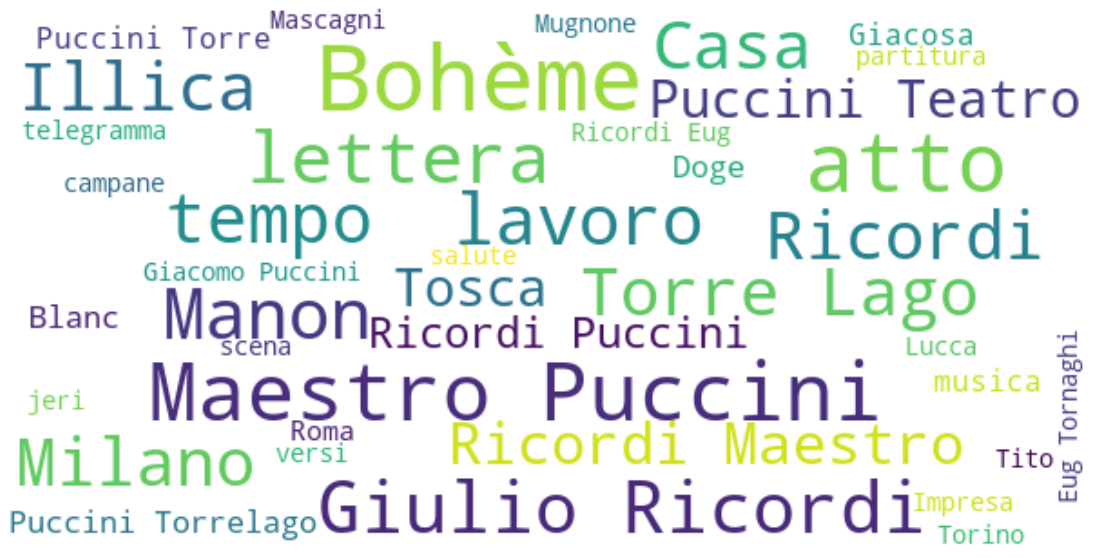

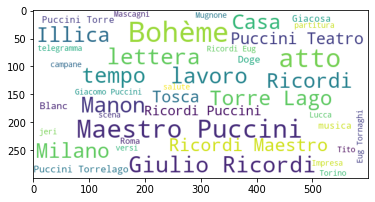

In [ ]:
text = (" ").join(letters_list)

remove = ['il',	'lo',	'la',	'l',	'i',	'gli',	'le',"pel",
'di'	,'del',	'dello',	'della',	'dell',	'dei'	,'degli'	,'delle',
'a',	'al'	,'allo',	'alla',	'all',	'ai',	'agli',	'alle',
'da',	'dal',	'dallo',	'dalla',	'dall',	'dai',	'dagli',	'dalle', 'Ella','ella',
'in',	'nel'	,'nello',	'nella',	'nell',	'nei',	'negli',	'nelle','ch',
'su',	'sul',	'sullo',	'sulla'	,'sull'	,'sui',	'sugli'	,'sulle',"proposito", "benissimo",
'se', 'si', 'mi', 'quale', 'mio','molto','tanto','Ma',"vero","credo","mai","occore","sapere","risposta","occorre","tale","far","ordine","speriamo","possesso","caso","va","pp","piacere","aspetto","gran","possa","cordialissimi","conto","auguro","Evviva","nome","cose","deve","dire","mando","utile","aff","fino","Gerente","momento","Carissimo","volta","Ditta","verso","possibile","cose","allora","troppo","altri","Soci","potrà","posso","notizie","fine","può","tre","cordiali","Saluti","buona","sera","ritorno","perchè","stato","dare","appena","prove","quel","né","nè","amico","bisogna","libretto","ogni","giorni","essere","colla","certo","stesso","poco","auguri","so","pare", "successo", "contratto","Caro","nuovo","opera","fra","solo", "domani", "tutte", "giorno","senza", 'stretta','mano','Spero','modo','mia','bene', 'così','fatto', 'subito','fare','sempre','sua', 'lei','lui','ciò','che','per','me', 'ad','ed','dopo','vi','quali','dice','grande','altre', 'presto','meglio','quando','quello', 'altro', 'ci', 'cui','poi','te','ma','proprio','Sig','avere','quindi','anche', 'come', 'sono','ora','più','sia','prima','parte','qui', 'tutta','assai','nulla','perché', 'non','fu','due','tu', 'pure','fa','però','qualche', 'col','ne','oggi','quando', 'io', 'tutto', 'dunque', 'ancora', 'ti', 'già','con','ho','cosa','intanto','ha' ]
remove_all = remove + list(stopwords.words('italian'))


wordcloud = WordCloud(max_font_size=50, max_words=40, stopwords=remove_all, background_color="white",width=600, height=300).generate(text)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
 
plt.imshow(wordcloud)

In [ ]:
import nltk
nltk.download('words')
words = set(nltk.corpus.words.words())

#sent = "Io andiamo to the beach with my amico."
#" ".join(w for w in nltk.wordpunct_tokenize(sent) \
#         if w.lower() in words or not w.isalpha())

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [ ]:
words

<br>
<br>


# **Pre-processing data**# 

In [ ]:
train = pd.read_csv('https://raw.githubusercontent.com/Andreaierardi/sentiment-puccini/main/dataset/training_set_sentipolc16%203.csv')
train

,idtwitter,subj,opos,oneg,iro,lpos,lneg,top,text
0,122449983151669248,1,0,1,0,0,1,1,Intanto la partita per Via Nazionale si compli...
1,125485104863780865,1,0,1,0,0,1,1,"False illusioni, sgradevoli realtà Mario Monti..."
2,125513454315507712,1,0,1,0,0,1,1,"False illusioni, sgradevoli realtà #editoriale..."
3,125524238290522113,1,0,1,0,0,1,1,Mario Monti: Berlusconi risparmi all'Italia il...
4,125527933224886272,1,0,1,0,0,1,1,Mario Monti: Berlusconi risparmi all'Italia il...
...,...,...,...,...,...,...,...,...,...
7405,135136897000415233,1,1,0,1,1,1,1,"che ci frega di mario monti, noi abbiamo mario..."
7406,143471916534087680,1,1,0,1,1,0,1,Strepitoso il titolo in prima di Libero sul go...
7407,153955345411219456,1,0,1,1,1,0,1,"@nataliacavalli Consolati, il governo #Monti h..."
7408,190835515552047104,1,1,0,1,1,1,0,"@SheisCandida beh, beate loro! Io nn possiedo ..."


In [ ]:
def get_sent_feature(df):
  sent = []
  for i, j in df[['opos','oneg', 'text']].iterrows():
    if j['opos'] == 1 and j['oneg'] == 1:
      sent.append(2)
    elif j['opos'] == 0 and j['oneg'] == 1:
      sent.append(-1)
    elif j['opos'] == 1 and  j['oneg'] == 0:
      sent.append(1)
    else:
      sent.append(0)
  return sent

In [ ]:
def get_sent_feature_binary(df):
  sent = []
  for i, j in df[['opos','oneg', 'text']].iterrows():
    if j['opos'] == 1 and j['oneg'] == 1:
      sent.append(2)
    elif j['opos'] == 0 and j['oneg'] == 1:
      sent.append(-1)
    elif j['opos'] == 1 and  j['oneg'] == 0:
      sent.append(1)
    else:
      sent.append(2)
  return sent

In [ ]:
train['sent'] = get_sent_feature(train)

In [ ]:
train_binary = train.copy()
train_binary['sent'] = get_sent_feature_binary(train)
train_binary = train_binary[train_binary['sent'] !=2]

In [ ]:
training_set = train.drop(labels=[ "idtwitter", 'subj','opos','oneg','lpos','lneg', 'top','iro'], axis=1)

In [ ]:
training_set_binary = train_binary.drop(labels=[ "idtwitter", 'subj','opos','oneg','lpos','lneg', 'top','iro'], axis=1)

In [ ]:
training_set

,text,sent
0,Intanto la partita per Via Nazionale si compli...,-1
1,"False illusioni, sgradevoli realtà Mario Monti...",-1
2,"False illusioni, sgradevoli realtà #editoriale...",-1
3,Mario Monti: Berlusconi risparmi all'Italia il...,-1
4,Mario Monti: Berlusconi risparmi all'Italia il...,-1
...,...,...
7405,"che ci frega di mario monti, noi abbiamo mario...",1
7406,Strepitoso il titolo in prima di Libero sul go...,1
7407,"@nataliacavalli Consolati, il governo #Monti h...",-1
7408,"@SheisCandida beh, beate loro! Io nn possiedo ...",1


In [ ]:
training_set_binary

,text,sent
0,Intanto la partita per Via Nazionale si compli...,-1
1,"False illusioni, sgradevoli realtà Mario Monti...",-1
2,"False illusioni, sgradevoli realtà #editoriale...",-1
3,Mario Monti: Berlusconi risparmi all'Italia il...,-1
4,Mario Monti: Berlusconi risparmi all'Italia il...,-1
...,...,...
7405,"che ci frega di mario monti, noi abbiamo mario...",1
7406,Strepitoso il titolo in prima di Libero sul go...,1
7407,"@nataliacavalli Consolati, il governo #Monti h...",-1
7408,"@SheisCandida beh, beate loro! Io nn possiedo ...",1


In [ ]:
test_set = pd.read_csv('https://raw.githubusercontent.com/Andreaierardi/sentiment-puccini/main/dataset/test_set_sentipolc16_gold2000%202.csv', error_bad_lines=False, header=None)
test_set.columns = train.columns[:-1]

b'Skipping line 110: expected 9 fields, saw 10\nSkipping line 131: expected 9 fields, saw 10\nSkipping line 213: expected 9 fields, saw 10\nSkipping line 273: expected 9 fields, saw 10\nSkipping line 282: expected 9 fields, saw 10\nSkipping line 283: expected 9 fields, saw 10\nSkipping line 296: expected 9 fields, saw 10\nSkipping line 304: expected 9 fields, saw 10\nSkipping line 321: expected 9 fields, saw 10\nSkipping line 361: expected 9 fields, saw 17\nSkipping line 428: expected 9 fields, saw 10\nSkipping line 453: expected 9 fields, saw 10\nSkipping line 518: expected 9 fields, saw 10\nSkipping line 539: expected 9 fields, saw 17\nSkipping line 568: expected 9 fields, saw 10\nSkipping line 579: expected 9 fields, saw 10\nSkipping line 599: expected 9 fields, saw 10\nSkipping line 631: expected 9 fields, saw 10\nSkipping line 668: expected 9 fields, saw 10\nSkipping line 769: expected 9 fields, saw 11\nSkipping line 801: expected 9 fields, saw 10\nSkipping line 802: expected 9 fi

In [ ]:
test_set

,idtwitter,subj,opos,oneg,iro,lpos,lneg,top,text
0,507074506880712705,0,0,0,0,0,0,2,Tra 5 minuti presentazione piano scuola del go...
1,507075789456961536,1,1,0,0,1,0,2,\@matteorenzi: Alle 10 appuntamento su http://...
2,507077511902425088,1,0,1,0,0,1,2,#labuonascuola gli #evangelisti #digitali non ...
3,507079183315787777,0,0,0,0,0,0,2,Riforma scuola Tutto il discorso di Renzi su ...
4,507080190225563648,1,0,0,0,0,0,2,.@matteorenzi @MiurSocial #labuonascuola basta...
...,...,...,...,...,...,...,...,...,...
1938,645372190645481472,0,0,0,0,0,0,0,Anche prodotti alimentari tipici pugliesi in v...
1939,645628412225265664,0,0,0,0,0,0,0,intensità di vita https://t.co/jv4aARxzhz
1940,645919232367161344,1,1,1,0,1,1,0,Oggi tutti che iniziano l'università e io sul ...
1941,648567080107790336,1,0,1,0,0,1,0,@GliIntoccabili @nonleggerlo Ma Ferrero? il co...


In [ ]:
test_set['sent'] = get_sent_feature(test_set)

In [ ]:
test_set_binary = test_set.copy()
test_set_binary['sent'] = get_sent_feature_binary(test_set)
test_set_binary = test_set_binary[test_set_binary['sent'] != 2]

In [ ]:
test_set = test_set.drop(labels=[ "idtwitter", 'subj','opos','oneg','lpos','lneg', 'top','iro'], axis=1)

In [ ]:
test_set_binary = test_set_binary.drop(labels=[ "idtwitter", 'subj','opos','oneg','lpos','lneg', 'top','iro'], axis=1)

In [ ]:
test_set

,text,sent
0,Tra 5 minuti presentazione piano scuola del go...,0
1,\@matteorenzi: Alle 10 appuntamento su http://...,1
2,#labuonascuola gli #evangelisti #digitali non ...,-1
3,Riforma scuola Tutto il discorso di Renzi su ...,0
4,.@matteorenzi @MiurSocial #labuonascuola basta...,0
...,...,...
1938,Anche prodotti alimentari tipici pugliesi in v...,0
1939,intensità di vita https://t.co/jv4aARxzhz,0
1940,Oggi tutti che iniziano l'università e io sul ...,2
1941,@GliIntoccabili @nonleggerlo Ma Ferrero? il co...,-1


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.utils import shuffle


x_train = training_set.drop(["sent"],axis=1)
y_train = training_set["sent"]

x_train, y_train =  shuffle(x_train, y_train)
x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)


x_train_binary = training_set_binary.drop(["sent"],axis=1)
y_train_binary = training_set_binary["sent"]

x_train_binary, y_train_binary =  shuffle(x_train_binary, y_train_binary)
x_train_binary = x_train_binary.reset_index(drop=True)
y_train_binary = y_train_binary.reset_index(drop=True)


In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.20)

In [ ]:
x_train_binary, x_valid_binary, y_train_binary, y_valid_binary = train_test_split(x_train_binary, y_train_binary, test_size=0.20)

In [ ]:
x_test = test_set.drop(["sent"],axis=1)
y_test = test_set["sent"]

x_test, y_test =  shuffle(x_test, y_test)
x_test = x_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [ ]:
x_test_binary = test_set_binary.drop(["sent"],axis=1)
y_test_binary = test_set_binary["sent"]

x_test_binary, y_test_binary =  shuffle(x_test_binary, y_test_binary)
x_test_binary = x_test_binary.reset_index(drop=True)
y_test_binary = y_test_binary.reset_index(drop=True)

In [ ]:
print("Shapes")
print("Train")
print("x_train",x_train.shape)
print("y_train",y_train.shape)
print("")
print("Valid")
print("x_valid",x_valid.shape)
print("y_valid",y_valid.shape)
print("")
print("Test")
print("x_test",x_test.shape)
print("y_test",y_test.shape)

Shapes
Train
x_train (5928, 1)
y_train (5928,)

Valid
x_valid (1482, 1)
y_valid (1482,)

Test
x_test (1943, 1)
y_test (1943,)


In [ ]:
print("Shapes")
print("Train_binary")
print("x_train_binary",x_train_binary.shape)
print("y_train_binary",y_train_binary.shape)
print("")
print("Valid")
print("x_valid_binary",x_valid_binary.shape)
print("y_valid_binary",y_valid_binary.shape)
print("")
print("Test")
print("x_test_binary",x_test_binary.shape)
print("y_test_binary",y_test_binary.shape)

Shapes
Train_binary
x_train_binary (3323, 1)
y_train_binary (3323,)

Valid
x_valid_binary (831, 1)
y_valid_binary (831,)

Test
x_test_binary (1018, 1)
y_test_binary (1018,)


In [ ]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

# Custom Transformer (Inheriting from classes)
class CleanText( BaseEstimator, TransformerMixin ):
    
   
    def __init__( self, lang = "italian"):
        self.lang = lang
        self.stemmer = SnowballStemmer(self.lang)
    
       
    def fit( self, X, y = None ):
        return self 
    
   
    def clean( self, x ):
        words   = [self.stemmer.stem(word) for word in word_tokenize(x.lower()) if word.isalpha() and word not in stopwords.words("italian")]
        return " ".join(words)
    
   
    def transform( self, X, y = None ):
        return X["text"].apply(self.clean)

In [ ]:
class CustomFeatures( BaseEstimator, TransformerMixin ):
    
    def __init__( self ):
        return
    
    def fit( self, X, y = None ):
        return self 
        
    def transform( self, X, y = None ):
        f           = pd.DataFrame()
        f['len']    = X['text'].str.len()
        f['digits'] = X['text'].str.findall(r'\d').str.len()
        f['punct']  = X['text'].str.findall(r'[^a-zA-Z\d\s:]').str.len()
        return f[['len','digits','punct']]

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler


pipe = Pipeline([("extract", FeatureUnion([("terms", Pipeline([('clean', CleanText()), 
                                                               ('tfidf', TfidfVectorizer())])),
                                           ("custom", CustomFeatures())])),
                 ("select", SelectKBest(score_func = chi2)),
                 ("scale", StandardScaler(with_mean = False))])

pipe_binary = Pipeline([("extract", FeatureUnion([("terms", Pipeline([('clean', CleanText()), 
                                                               ('tfidf', TfidfVectorizer())])),
                                           ("custom", CustomFeatures())])),
                 ("select", SelectKBest(score_func = chi2)),
                 ("scale", StandardScaler(with_mean = False))])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
pipe.fit(x_train,y_train)

Pipeline(steps=[('extract',
                 FeatureUnion(transformer_list=[('terms',
                                                 Pipeline(steps=[('clean',
                                                                  CleanText()),
                                                                 ('tfidf',
                                                                  TfidfVectorizer())])),
                                                ('custom', CustomFeatures())])),
                ('select',
                 SelectKBest(score_func=<function chi2 at 0x7f44cdbaeb00>)),
                ('scale', StandardScaler(with_mean=False))])

In [ ]:
pipe_binary.fit(x_train_binary,y_train_binary)

Pipeline(steps=[('extract',
                 FeatureUnion(transformer_list=[('terms',
                                                 Pipeline(steps=[('clean',
                                                                  CleanText()),
                                                                 ('tfidf',
                                                                  TfidfVectorizer())])),
                                                ('custom', CustomFeatures())])),
                ('select',
                 SelectKBest(score_func=<function chi2 at 0x7f44cdbaeb00>)),
                ('scale', StandardScaler(with_mean=False))])

In [ ]:
X_train = pipe.fit_transform(x_train,y_train)

In [ ]:
X_train_binary= pipe_binary.fit_transform(x_train_binary,y_train_binary)

In [ ]:
X_valid = pipe.transform(x_valid)
X_test = pipe.transform(x_test)
X_letters = pipe.transform(letters_df[['text']])

In [ ]:
X_valid_binary = pipe_binary.transform(x_valid_binary)
X_test_binary = pipe_binary.transform(x_test_binary)
X_letters_binary = pipe_binary.transform(letters_df[['text']])

In [ ]:
# extract features
pipe_extract = FeatureUnion([("terms", Pipeline([('clean', CleanText()), 
                                                 ('tfidf', TfidfVectorizer())])),
                             ("custom", CustomFeatures())])

# select and scale features
pipe_select_scale = Pipeline([("select", SelectKBest(score_func = chi2)),
                              ("scale", StandardScaler(with_mean = False))])


# extract features
# you can also use bi-grams:
X_extract = pipe_extract.set_params(terms__tfidf__ngram_range = (1,2)).fit_transform(x_train, y_train)

X_extract_test = pipe_extract.set_params(terms__tfidf__ngram_range = (1,2)).transform(x_test)

X_extract_letters =  pipe_extract.set_params(terms__tfidf__ngram_range = (1,2)).transform(letters_df[['text']] )
print(X_extract)

X_select_scale = pipe_select_scale.set_params(select__k = 500).fit_transform(X_extract, y_train)
print(X_select_scale)

X_select_scale_test = pipe_select_scale.set_params(select__k = 500).transform(X_extract_test)
print(X_select_scale)

X_select_scale_letters = pipe_select_scale.set_params(select__k = 500).transform(X_extract_letters)


In [ ]:
# extract features
pipe_extract_binary = FeatureUnion([("terms", Pipeline([('clean', CleanText()), 
                                                 ('tfidf', TfidfVectorizer())])),
                             ("custom", CustomFeatures())])

# select and scale features
pipe_select_scale_binary = Pipeline([("select", SelectKBest(score_func = chi2)),
                              ("scale", StandardScaler(with_mean = False))])


# extract features
# you can also use bi-grams:
X_extract_binary = pipe_extract_binary.set_params(terms__tfidf__ngram_range = (1,2)).fit_transform(x_train_binary, y_train_binary)

X_extract_test_binary = pipe_extract_binary.set_params(terms__tfidf__ngram_range = (1,2)).transform(x_test_binary)

X_extract_letters_binary =  pipe_extract_binary.set_params(terms__tfidf__ngram_range = (1,2)).transform(letters_df[['text']] )
print(X_extract_binary)

X_select_scale_binary = pipe_select_scale_binary.set_params(select__k = 500).fit_transform(X_extract_binary, y_train_binary)
print(X_select_scale_binary)

X_select_scale_test_binary = pipe_select_scale_binary.set_params(select__k = 500).transform(X_extract_test_binary)
print(X_select_scale_binary)

X_select_scale_letters_binary = pipe_select_scale_binary.set_params(select__k = 500).transform(X_extract_letters_binary)


In [ ]:
# extract features
pipe_bi = Pipeline([("extract", FeatureUnion([("terms", Pipeline([('clean', CleanText()), 
                                                               ('tfidf', TfidfVectorizer(ngram_range = (1,2)))])),
                                           ("custom", CustomFeatures())])),
                 ("select", SelectKBest(score_func = chi2,k = 500)),
                 ("scale", StandardScaler(with_mean = False))])


In [ ]:
# extract features
pipe_bi_binary = Pipeline([("extract", FeatureUnion([("terms", Pipeline([('clean', CleanText()), 
                                                               ('tfidf', TfidfVectorizer(ngram_range = (1,2)))])),
                                           ("custom", CustomFeatures())])),
                 ("select", SelectKBest(score_func = chi2,k = 500)),
                 ("scale", StandardScaler(with_mean = False))])


In [ ]:
X_train_bi =pipe_bi.fit_transform(x_train,y_train)
X_valid_bi = pipe_bi.transform(x_valid)
X_test_bi = pipe_bi.transform(x_test)

X_letters_bi = pipe_bi.transform(letters_df[['text']])

In [ ]:
X_train_bi_binary =pipe_bi_binary.fit_transform(x_train_binary,y_train_binary)
X_valid_bi_binary = pipe_bi_binary.transform(x_valid_binary)
X_test_bi_binary = pipe_bi_binary.transform(x_test_binary)

X_letters_bi_binary = pipe_bi_binary.transform(letters_df[['text']])

In [ ]:
from sklearn import preprocessing
le_binary = preprocessing.LabelEncoder()

y_train_enc_binary = le_binary.fit_transform(y_train_binary)
y_valid_enc_binary = le_binary.transform(y_valid_binary)
y_test_enc_binary = le_binary.transform(y_test_binary)

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

y_train_enc = le.fit_transform(y_train)
y_valid_enc = le.transform(y_valid)
y_test_enc = le.transform(y_test)

In [ ]:
import numpy as np
from keras.utils import np_utils

no_of_classes = len(np.unique(y_train))
y_train_seq = np_utils.to_categorical(y_train_enc,no_of_classes)
y_valid_seq = np_utils.to_categorical(y_valid_enc,no_of_classes)
y_test_seq= np_utils.to_categorical(y_test_enc,no_of_classes)

In [ ]:
import numpy as np
from keras.utils import np_utils

no_of_classes_binary = len(np.unique(y_train_binary))
y_train_seq_binary = np_utils.to_categorical(y_train_enc_binary,no_of_classes_binary)
y_valid_seq_binary = np_utils.to_categorical(y_valid_enc_binary,no_of_classes_binary)
y_test_seq_binary= np_utils.to_categorical(y_test_enc_binary,no_of_classes_binary)

# Logistic

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# Select best hyperparameters by cross validation
from sklearn.model_selection import GridSearchCV
import numpy as np

# Model
logistic = LogisticRegression(max_iter=10000, tol=0.1, solver='lbfgs')

param_logistic = {
    'C': np.logspace(-4, 4, 4),
}


cv_logistic = GridSearchCV(logistic, param_logistic, cv=10, scoring="f1_weighted")
cv_logistic.fit(X_train_bi_binary, y_train_enc_binary)

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=10000, tol=0.1),
             param_grid={'C': array([1.00000000e-04, 4.64158883e-02, 2.15443469e+01, 1.00000000e+04])},
             scoring='f1_weighted')

In [ ]:
print(cv_logistic.best_score_)

0.8120010793671704


In [ ]:
from sklearn.metrics import f1_score
y_pred = cv_logistic.predict(X_test_bi_binary)
print(f1_score(y_test_enc_binary, y_pred, average="weighted"))


0.6318610344312837


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score


rf =  RandomForestClassifier(n_estimators=100,max_depth=None)

In [ ]:
rf.fit(X_train_bi,y_train_enc)
y_pred = rf.predict(X_test_bi)
f1_score(y_test_enc, y_pred, average="weighted")



0.4077977950535332

<hr>
<br>
<br>

# CV Neural Networks 

<br>


In [ ]:
!pip install keras-visualizer

In [ ]:
from keras_visualizer import visualizer 
from keras.callbacks import History
import tensorflow as tf
import keras
from keras import layers
from keras import models
from keras import utils
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation
from keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop

In [ ]:
def createNN_tuning_binary(init_mode='uniform',drop_out=0.1, init_nodes1 =64, init_nodes2 = 64,dim = 500):
    # define model
    model = Sequential()
    model.add(Dense(init_nodes1, kernel_initializer=init_mode, activation=tf.nn.relu, input_dim=dim)) 
    model.add(Dropout(drop_out))
    model.add(Dense(init_nodes2, kernel_initializer=init_mode, activation=tf.nn.relu))
    model.add(Dense(1, kernel_initializer=init_mode, activation=tf.nn.sigmoid))
    # compile model
    model.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
    return model

In [ ]:
import numpy
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

def createNN_tuning(init_mode='uniform',drop_out=0.1, init_nodes1 =64, init_nodes2 = 64,dim = 500):
    # define model
    model = Sequential()
    model.add(Dense(init_nodes1, kernel_initializer=init_mode, activation=tf.nn.relu, input_dim=dim)) 
    model.add(Dropout(drop_out))
    model.add(Dense(init_nodes2, kernel_initializer=init_mode, activation=tf.nn.relu))
    model.add(Dense(4, kernel_initializer=init_mode, activation=tf.nn.softmax))
    # compile model
    model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])
    return model

In [ ]:
seed = 7
numpy.random.seed(seed)
batch_size = 128
epochs = 50

model_CV_binary = KerasClassifier(build_fn=createNN_tuning_binary,  
                           batch_size=batch_size, verbose=1,  )



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  import sys


In [ ]:
seed = 7
numpy.random.seed(seed)
batch_size = 128
epochs = 50

model_CV = KerasClassifier(build_fn=createNN_tuning,  
                           batch_size=batch_size, verbose=1,  )



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  import sys


In [ ]:
# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'normal']
init_nodes1 = [64,128,256]
init_nodes2 = [64,128,256]
drop_out = [0.1,0.3,0.5]
epochs = [30,50]

param_grid = dict(init_mode=init_mode, init_nodes1 = init_nodes1, init_nodes2 = init_nodes2, drop_out= drop_out,epochs= epochs)


In [ ]:
grid_binary = GridSearchCV(estimator=model_CV_binary, param_grid=param_grid, n_jobs=-1, cv=3)


In [ ]:
grid = GridSearchCV(estimator=model_CV, param_grid=param_grid, n_jobs=-1, cv=3)


In [ ]:
#%%time
#grid_result_binary = grid_binary.fit(X_train_bi_binary, y_train_enc_binary,validation_data=(X_valid_bi_binary, y_valid_enc_binary))

In [ ]:
#%%time
#grid_result = grid.fit(X_train_bi, y_train_seq,validation_data=(X_valid_bi, y_valid_seq))

In [ ]:
#y_pred_binary= grid_result_binary.predict(X_test_binary)
#y_pred_enc_binary = [np.argmax(i) for i in y_pred_binary]
#f1_score(y_test_enc_binary, y_pred_enc_binary, average="weighted")

In [ ]:
#from sklearn.metrics import f1_score
#y_pred= grid_result.predict(X_test_bi)
#y_pred_enc = [np.argmax(i) for i in y_pred]
#f1_score(y_test_enc, y_pred_enc, average="weighted")

In [ ]:
#print(f'Best Accuracy for {grid_result_binary.best_score_} using {grid_result_binary.best_params_}')
#means_binary = grid_result_binary.cv_results_['mean_test_score']
#stds_binary = grid_result_binary.cv_results_['std_test_score']
#params_binary = grid_result_binary.cv_results_['params']
#for mean, stdev, param in zip(means_binary, stds_binary, params_binary):
#    print(f' mean={mean:.4}, std={stdev:.4} using {param}')

In [ ]:
# print results
#print(f'Best Accuracy for {grid_result.best_score_} using {grid_result.best_params_}')
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print(f' mean={mean:.4}, std={stdev:.4} using {param}')

Best Accuracy for 0.5506073037783304 using {'drop_out': 0.5, 'epochs': 50, 'init_mode': 'normal', 'init_nodes1': 64, 'init_nodes2': 256}
 mean=0.5471, std=0.01136 using {'drop_out': 0.1, 'epochs': 50, 'init_mode': 'uniform', 'init_nodes1': 64, 'init_nodes2': 64}
 mean=0.5444, std=0.009833 using {'drop_out': 0.1, 'epochs': 50, 'init_mode': 'uniform', 'init_nodes1': 64, 'init_nodes2': 128}
 mean=0.5366, std=0.01055 using {'drop_out': 0.1, 'epochs': 50, 'init_mode': 'uniform', 'init_nodes1': 64, 'init_nodes2': 256}
 mean=0.541, std=0.01032 using {'drop_out': 0.1, 'epochs': 50, 'init_mode': 'uniform', 'init_nodes1': 128, 'init_nodes2': 64}
 mean=0.5415, std=0.01118 using {'drop_out': 0.1, 'epochs': 50, 'init_mode': 'uniform', 'init_nodes1': 128, 'init_nodes2': 128}
 mean=0.5341, std=0.01009 using {'drop_out': 0.1, 'epochs': 50, 'init_mode': 'uniform', 'init_nodes1': 128, 'init_nodes2': 256}
 mean=0.5371, std=0.009729 using {'drop_out': 0.1, 'epochs': 50, 'init_mode': 'uniform', 'init_nodes1': 256, 'init_nodes2': 64}
 mean=0.5358, std=0.01328 using {'drop_out': 0.1, 'epochs': 50, 'init_mode': 'uniform', 'init_nodes1': 256, 'init_nodes2': 128}
 mean=0.5307, std=0.007499 using {'drop_out': 0.1, 'epochs': 50, 'init_mode': 'uniform', 'init_nodes1': 256, 'init_nodes2': 256}
 mean=0.5401, std=0.01408 using {'drop_out': 0.1, 'epochs': 50, 'init_mode': 'lecun_uniform', 'init_nodes1': 64, 'init_nodes2': 64}
 mean=0.5326, std=0.01122 using {'drop_out': 0.1, 'epochs': 50, 'init_mode': 'lecun_uniform', 'init_nodes1': 64, 'init_nodes2': 128}
 mean=0.5386, std=0.01049 using {'drop_out': 0.1, 'epochs': 50, 'init_mode': 'lecun_uniform', 'init_nodes1': 64, 'init_nodes2': 256}
 mean=0.5294, std=0.01242 using {'drop_out': 0.1, 'epochs': 50, 'init_mode': 'lecun_uniform', 'init_nodes1': 128, 'init_nodes2': 64}
 mean=0.53, std=0.00948 using {'drop_out': 0.1, 'epochs': 50, 'init_mode': 'lecun_uniform', 'init_nodes1': 128, 'init_nodes2': 128}
 mean=0.5231, std=0.01222 using {'drop_out': 0.1, 'epochs': 50, 'init_mode': 'lecun_uniform', 'init_nodes1': 128, 'init_nodes2': 256}
 mean=0.5278, std=0.006951 using {'drop_out': 0.1, 'epochs': 50, 'init_mode': 'lecun_uniform', 'init_nodes1': 256, 'init_nodes2': 64}
 mean=0.5238, std=0.005466 using {'drop_out': 0.1, 'epochs': 50, 'init_mode': 'lecun_uniform', 'init_nodes1': 256, 'init_nodes2': 128}
 mean=0.5155, std=0.01508 using {'drop_out': 0.1, 'epochs': 50, 'init_mode': 'lecun_uniform', 'init_nodes1': 256, 'init_nodes2': 256}
 mean=0.5417, std=0.00836 using {'drop_out': 0.1, 'epochs': 50, 'init_mode': 'normal', 'init_nodes1': 64, 'init_nodes2': 64}
 mean=0.5376, std=0.01222 using {'drop_out': 0.1, 'epochs': 50, 'init_mode': 'normal', 'init_nodes1': 64, 'init_nodes2': 128}
 mean=0.5374, std=0.01043 using {'drop_out': 0.1, 'epochs': 50, 'init_mode': 'normal', 'init_nodes1': 64, 'init_nodes2': 256}

In [ ]:
#_, accuracy_binary = grid_result_binary.evaluate(X_test_bi_binary, y_test_seq_binary)
#print('Accuracy: %.2f' % (accuracy_binary*100))

In [ ]:
#_, accuracy = grid_result.evaluate(X_test_bi, y_test_seq)
#print('Accuracy: %.2f' % (accuracy*100))

In [ ]:
#grid_result_binary.best_params_

In [ ]:
#grid_result.best_params_

{'drop_out': 0.5, 'epochs': 50, 'init_nodes1': 64, 'init_nodes2': 128}

In [ ]:
model_earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

In [ ]:
nn_tune_binary= createNN_tuning_binary(drop_out=0.5, init_mode="normal",init_nodes1=64, init_nodes2 = 128)

In [ ]:
nn_tune= createNN_tuning(drop_out=0.5, init_mode="normal",init_nodes1=64, init_nodes2 = 256)

In [ ]:
history_tune_binary = nn_tune_binary.fit(X_train_bi_binary, y_train_enc_binary,validation_data=(X_valid_bi_binary, y_valid_enc_binary), epochs=30, batch_size=1024,callbacks=model_earlystop)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_6/dense_18/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_6/dense_18/embedding_lookup_sparse/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_6/dense_18/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


4/4 [==============================] - 1s 67ms/step - loss: 0.6927 - accuracy: 0.5998 - val_loss: 0.6804 - val_accuracy: 0.6173
Epoch 2/30
4/4 [==============================] - 0s 14ms/step - loss: 0.6733 - accuracy: 0.6286 - val_loss: 0.6735 - val_accuracy: 0.6197
Epoch 3/30
4/4 [==============================] - 0s 16ms/step - loss: 0.6540 - accuracy: 0.6804 - val_loss: 0.6556 - val_accuracy: 0.6883
Epoch 4/30
4/4 [==============================] - 0s 17ms/step - loss: 0.6302 - accuracy: 0.7307 - val_loss: 0.6285 - val_accuracy: 0.7244
Epoch 5/30
4/4 [==============================] - 0s 15ms/step - loss: 0.6022 - accuracy: 0.7605 - val_loss: 0.5982 - val_accuracy: 0.7365
Epoch 6/30
4/4 [==============================] - 0s 16ms/step - loss: 0.5633 - accuracy: 0.7803 - val_loss: 0.5714 - val_accuracy: 0.7485
Epoch 7/30
4/4 [==============================] - 0s 15ms/step - loss: 0.5154 - accuracy: 0.7999 - val_loss: 0.5569 - val_accuracy: 0.7497
Epoch 8/30
4/4 [======================

In [ ]:
history_tune = nn_tune.fit(X_train_bi, y_train_seq,validation_data=(X_valid_bi, y_valid_seq), epochs=30, batch_size=512,callbacks=model_earlystop)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_7/dense_21/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_7/dense_21/embedding_lookup_sparse/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_7/dense_21/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


12/12 [==============================] - 1s 28ms/step - loss: 1.3275 - accuracy: 0.4167 - val_loss: 1.2514 - val_accuracy: 0.4825
Epoch 2/30
12/12 [==============================] - 0s 11ms/step - loss: 1.2016 - accuracy: 0.4880 - val_loss: 1.2063 - val_accuracy: 0.5034
Epoch 3/30
12/12 [==============================] - 0s 14ms/step - loss: 1.1372 - accuracy: 0.5083 - val_loss: 1.2085 - val_accuracy: 0.5108
Epoch 4/30
12/12 [==============================] - 0s 13ms/step - loss: 1.1018 - accuracy: 0.5243 - val_loss: 1.2106 - val_accuracy: 0.5128
Epoch 5/30
12/12 [==============================] - 0s 13ms/step - loss: 1.0714 - accuracy: 0.5369 - val_loss: 1.2171 - val_accuracy: 0.5189
Epoch 6/30
12/12 [==============================] - 0s 12ms/step - loss: 1.0579 - accuracy: 0.5476 - val_loss: 1.2245 - val_accuracy: 0.5270
Epoch 7/30
12/12 [==============================] - 0s 11ms/step - loss: 1.0519 - accuracy: 0.5467 - val_loss: 1.2308 - val_accuracy: 0.5209


In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  


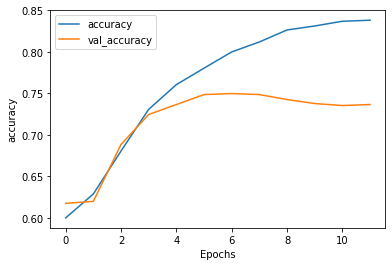

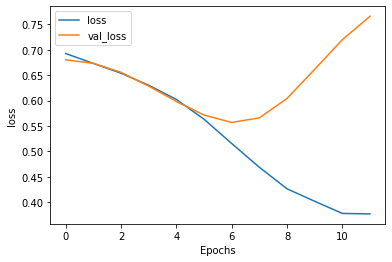

In [ ]:
plot_graphs(history_tune_binary, "accuracy")
plot_graphs(history_tune_binary, "loss")

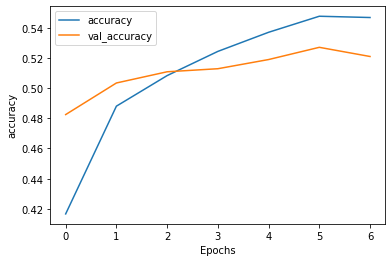

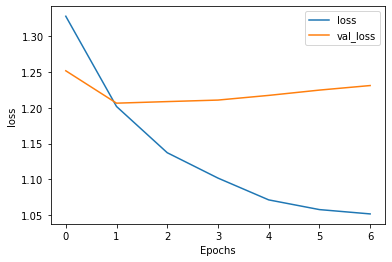

In [ ]:
plot_graphs(history_tune, "accuracy")
plot_graphs(history_tune, "loss")

In [ ]:
_, accuracy_binary = nn_tune_binary.evaluate(X_test_bi_binary, y_test_enc_binary)
print('Accuracy: %.2f' % (accuracy_binary*100))

32/32 [==============================] - 0s 3ms/step - loss: 1.0740 - accuracy: 0.6110
Accuracy: 61.10


In [ ]:
y_test_enc_binary

array([0, 1, 0, ..., 0, 1, 0])

In [ ]:
_, accuracy = nn_tune.evaluate(X_test_bi, y_test_seq)
print('Accuracy: %.2f' % (accuracy*100))

61/61 [==============================] - 0s 2ms/step - loss: 1.3651 - accuracy: 0.4508
Accuracy: 45.08


In [ ]:
from sklearn.metrics import f1_score
y_pred_binary= nn_tune_binary.predict(X_test_bi_binary)
y_pred_enc_binary =np.asarray(np.round(y_pred_binary)).astype(int)
f1_score(y_test_enc_binary, y_pred_enc_binary, average="weighted")

0.62312390348252

In [ ]:
from sklearn.metrics import f1_score
y_pred= nn_tune.predict(X_test_bi)
y_pred_enc = [np.argmax(i) for i in y_pred]
f1_score(y_test_enc, y_pred_enc, average="weighted")

0.46735078936164925

In [ ]:
#NN_cv.save('NN_cv.sav')

In [ ]:
pred = le.inverse_transform([np.argmax(i) for i in y_pred])

In [ ]:
pred

array([1, 1, 0, ..., 1, 0, 0])

In [ ]:
test_set

,text,sent
0,Tra 5 minuti presentazione piano scuola del go...,0
1,\@matteorenzi: Alle 10 appuntamento su http://...,1
2,#labuonascuola gli #evangelisti #digitali non ...,-1
3,Riforma scuola Tutto il discorso di Renzi su ...,0
4,.@matteorenzi @MiurSocial #labuonascuola basta...,0
...,...,...
1938,Anche prodotti alimentari tipici pugliesi in v...,0
1939,intensità di vita https://t.co/jv4aARxzhz,0
1940,Oggi tutti che iniziano l'università e io sul ...,2
1941,@GliIntoccabili @nonleggerlo Ma Ferrero? il co...,-1


In [ ]:
visualizer(nn_tune, format='png', view=True)

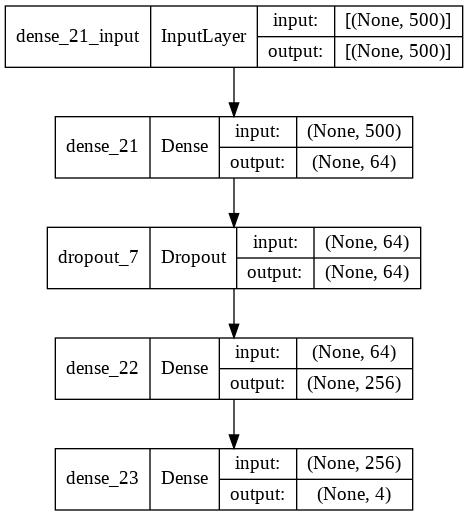

In [ ]:
from keras.utils.vis_utils import plot_model
 
plot_model(nn_tune, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
X_letters

<456x10 sparse matrix of type '<class 'numpy.float64'>'
	with 1287 stored elements in Compressed Sparse Row format>

In [ ]:
X_test_bi

<1943x500 sparse matrix of type '<class 'numpy.float64'>'
	with 6725 stored elements in Compressed Sparse Row format>

In [ ]:
X_letters_bi

<456x500 sparse matrix of type '<class 'numpy.float64'>'
	with 2115 stored elements in Compressed Sparse Row format>

In [ ]:
y_pred = nn_tune.predict(X_letters_bi)
y_pred_enc_bi = [np.argmax(i) for i in y_pred]
#f1_score(y_pred_enc_bi, y_pred_enc, average="weighted")

In [ ]:
y_pred_bin = nn_tune_binary.predict(X_letters_bi_binary)
y_pred_enc_bi_bin =np.asarray(np.round(y_pred_bin)).astype(int)

In [ ]:
letters_df

,id,text,emit,rec,date,place,segnatura_volume,anno,volume,pag,nr_pag,named_people,named_works,named_places,named_teatri,tipologia,sottotipologia,scrittura,linuga,year,sentiment_sentita,emotion_sentita
CLET000002,CLET000002,\nRicordi editore per Puccini\nNapoli\nnon dub...,Ricordi,Giacomo Puccini,1888-01-03,Milano,DOC00604,1887-1888,01,054,1,NaN,NaN,NaN,NaN,copialettere,telegramma,manoscritto,[italiano],1888,positive,joy
CLET000024,CLET000024,\nMilano 11 Agosto\nSig.r Maestro G. Pucini\nC...,Giulio Ricordi,Giacomo Puccini,1888-08-11,Milano,DOC00616,1888-1889,05,173,1,[Cesare Corti],NaN,NaN,NaN,copialettere,lettera,manoscritto,[italiano],1888,negative,sadness
CLET000026,CLET000026,\n11 Sett\n \nCarissimo M° Puccini\nAlbergo Pi...,Eugenio Tornaghi,Giacomo Puccini,1888-09-11,Milano,DOC00617,1888-1889,06,497,1,"[Franco Faccio, Giulio Ricordi]",[Edgar],NaN,NaN,copialettere,lettera,manoscritto,[italiano],1888,positive,joy
CLET000028,CLET000028,"\n16 7bre 8\nPreg.° S.° Maestro G. Puccini,...",Eugenio Tornaghi,Giacomo Puccini,1888-09-19,Milano,DOC00618,1888-1889,07,163,1,NaN,NaN,NaN,NaN,copialettere,lettera,manoscritto,[italiano],1888,negative,sadness
CLET000029,CLET000029,\n2 Novembre 8\nPreg° Sig Maestro\nGiacomo P...,Eugenio Tornaghi,Giacomo Puccini,1888-11-02,Milano,DOC00644,1889-1890,09,270,1,NaN,NaN,NaN,NaN,copialettere,lettera,manoscritto,[italiano],1888,positive,joy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CLET000782,CLET000782,\nPuccini.\nTorrelago.\nCasa Palermo avvisami ...,Ricordi,Giacomo Puccini,1901-03-15,Milano,DOC00870,1900-1901,17,104,1,[Augusto Lagan],[Tosca],NaN,NaN,copialettere,telegramma,manoscritto,[italiano],1888,negative,sadness
CLET000783,CLET000783,\n18 Marzo 1901\nIllustre Maestro\nComm.e G. P...,Ricordi,Giacomo Puccini,1901-03-18,Milano,DOC00870,1900-1901,17,248,1,[Elvira Puccini Bonturi],NaN,NaN,NaN,copialettere,lettera,manoscritto,[italiano],1888,negative,joy
CLET000784,CLET000784,\nMaestro Puccini\nTorre del Lago\nCome sa ten...,Ricordi,Giacomo Puccini,1901-03-19,Milano,DOC00870,1900-1901,17,279,1,[Cesare Corti],NaN,NaN,[Teatro Verdi],copialettere,telegramma,manoscritto,[italiano],1888,positive,joy
CLET000785,CLET000785,\nMaestro Puccini\nTeatro Massimo. Palermo\nSo...,Giulio Ricordi,Giacomo Puccini,1901-03-25,Milano,DOC00887,1901-1902,18,001,1,"[Leopoldo Mugnone, Elena Bianchini Cappelli, A...",[Tosca],NaN,"[Teatro Massimo, Teatro Verdi]",copialettere,telegramma,manoscritto,[italiano],1888,positive,joy


In [ ]:
letters_df

,id,text,emit,rec,date,place,segnatura_volume,anno,volume,pag,nr_pag,named_people,named_works,named_places,named_teatri,tipologia,sottotipologia,scrittura,linuga,year,sentiment_sentita,emotion_sentita
CLET000002,CLET000002,\nRicordi editore per Puccini\nNapoli\nnon dub...,Ricordi,Giacomo Puccini,1888-01-03,Milano,DOC00604,1887-1888,01,054,1,NaN,NaN,NaN,NaN,copialettere,telegramma,manoscritto,[italiano],1888,positive,joy
CLET000024,CLET000024,\nMilano 11 Agosto\nSig.r Maestro G. Pucini\nC...,Giulio Ricordi,Giacomo Puccini,1888-08-11,Milano,DOC00616,1888-1889,05,173,1,[Cesare Corti],NaN,NaN,NaN,copialettere,lettera,manoscritto,[italiano],1888,negative,sadness
CLET000026,CLET000026,\n11 Sett\n \nCarissimo M° Puccini\nAlbergo Pi...,Eugenio Tornaghi,Giacomo Puccini,1888-09-11,Milano,DOC00617,1888-1889,06,497,1,"[Franco Faccio, Giulio Ricordi]",[Edgar],NaN,NaN,copialettere,lettera,manoscritto,[italiano],1888,positive,joy
CLET000028,CLET000028,"\n16 7bre 8\nPreg.° S.° Maestro G. Puccini,...",Eugenio Tornaghi,Giacomo Puccini,1888-09-19,Milano,DOC00618,1888-1889,07,163,1,NaN,NaN,NaN,NaN,copialettere,lettera,manoscritto,[italiano],1888,negative,sadness
CLET000029,CLET000029,\n2 Novembre 8\nPreg° Sig Maestro\nGiacomo P...,Eugenio Tornaghi,Giacomo Puccini,1888-11-02,Milano,DOC00644,1889-1890,09,270,1,NaN,NaN,NaN,NaN,copialettere,lettera,manoscritto,[italiano],1888,positive,joy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CLET000782,CLET000782,\nPuccini.\nTorrelago.\nCasa Palermo avvisami ...,Ricordi,Giacomo Puccini,1901-03-15,Milano,DOC00870,1900-1901,17,104,1,[Augusto Lagan],[Tosca],NaN,NaN,copialettere,telegramma,manoscritto,[italiano],1888,negative,sadness
CLET000783,CLET000783,\n18 Marzo 1901\nIllustre Maestro\nComm.e G. P...,Ricordi,Giacomo Puccini,1901-03-18,Milano,DOC00870,1900-1901,17,248,1,[Elvira Puccini Bonturi],NaN,NaN,NaN,copialettere,lettera,manoscritto,[italiano],1888,negative,joy
CLET000784,CLET000784,\nMaestro Puccini\nTorre del Lago\nCome sa ten...,Ricordi,Giacomo Puccini,1901-03-19,Milano,DOC00870,1900-1901,17,279,1,[Cesare Corti],NaN,NaN,[Teatro Verdi],copialettere,telegramma,manoscritto,[italiano],1888,positive,joy
CLET000785,CLET000785,\nMaestro Puccini\nTeatro Massimo. Palermo\nSo...,Giulio Ricordi,Giacomo Puccini,1901-03-25,Milano,DOC00887,1901-1902,18,001,1,"[Leopoldo Mugnone, Elena Bianchini Cappelli, A...",[Tosca],NaN,"[Teatro Massimo, Teatro Verdi]",copialettere,telegramma,manoscritto,[italiano],1888,positive,joy


In [ ]:
letters_text_pred = letters_df[['text','year']]

In [ ]:
letters_text_pred

,text,year
CLET000002,\nRicordi editore per Puccini\nNapoli\nnon dub...,1888
CLET000024,\nMilano 11 Agosto\nSig.r Maestro G. Pucini\nC...,1888
CLET000026,\n11 Sett\n \nCarissimo M° Puccini\nAlbergo Pi...,1888
CLET000028,"\n16 7bre 8\nPreg.° S.° Maestro G. Puccini,...",1888
CLET000029,\n2 Novembre 8\nPreg° Sig Maestro\nGiacomo P...,1888
...,...,...
CLET000782,\nPuccini.\nTorrelago.\nCasa Palermo avvisami ...,1888
CLET000783,\n18 Marzo 1901\nIllustre Maestro\nComm.e G. P...,1888
CLET000784,\nMaestro Puccini\nTorre del Lago\nCome sa ten...,1888
CLET000785,\nMaestro Puccini\nTeatro Massimo. Palermo\nSo...,1888


In [ ]:
letters_text_pred['pred'] = y_pred_enc_bi
letters_df['pred'] = y_pred_enc_bi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
letters_text_pred['pred_binary'] = y_pred_enc_bi_bin
letters_df['pred_binary'] = y_pred_enc_bi_bin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
letters_text_pred

,text,year,pred,pred_binary
CLET000002,\nRicordi editore per Puccini\nNapoli\nnon dub...,1888,2,1
CLET000024,\nMilano 11 Agosto\nSig.r Maestro G. Pucini\nC...,1888,0,0
CLET000026,\n11 Sett\n \nCarissimo M° Puccini\nAlbergo Pi...,1888,2,0
CLET000028,"\n16 7bre 8\nPreg.° S.° Maestro G. Puccini,...",1888,0,0
CLET000029,\n2 Novembre 8\nPreg° Sig Maestro\nGiacomo P...,1888,0,0
...,...,...,...,...
CLET000782,\nPuccini.\nTorrelago.\nCasa Palermo avvisami ...,1888,0,1
CLET000783,\n18 Marzo 1901\nIllustre Maestro\nComm.e G. P...,1888,2,1
CLET000784,\nMaestro Puccini\nTorre del Lago\nCome sa ten...,1888,2,1
CLET000785,\nMaestro Puccini\nTeatro Massimo. Palermo\nSo...,1888,2,1


<hr>

<br>
<br>

# Sentita Sentiment and Emotion Classifiers

<br>

In [ ]:
letters_df = pd.read_pickle('https://github.com/Andreaierardi/sentiment-puccini/blob/main/dataset/puccini.pkl?raw=true')

In [ ]:
letters_list = list(letters_df['text'])

In [ ]:
letters_df

,id,text,emit,rec,date,place,segnatura_volume,anno,volume,pag,nr_pag,named_people,named_works,named_places,named_teatri,tipologia,sottotipologia,scrittura,linuga
CLET000002,CLET000002,\nRicordi editore per Puccini\nNapoli\nnon dub...,Ricordi,Giacomo Puccini,3/1/1888,Milano,DOC00604,1887-1888,01,054,1,NaN,NaN,NaN,NaN,copialettere,telegramma,manoscritto,[italiano]
CLET000024,CLET000024,\nMilano 11 Agosto\nSig.r Maestro G. Pucini\nC...,Giulio Ricordi,Giacomo Puccini,11/8/1888,Milano,DOC00616,1888-1889,05,173,1,[Cesare Corti],NaN,NaN,NaN,copialettere,lettera,manoscritto,[italiano]
CLET000026,CLET000026,\n11 Sett\n \nCarissimo M° Puccini\nAlbergo Pi...,Eugenio Tornaghi,Giacomo Puccini,11/9/1888,Milano,DOC00617,1888-1889,06,497,1,"[Franco Faccio, Giulio Ricordi]",[Edgar],NaN,NaN,copialettere,lettera,manoscritto,[italiano]
CLET000028,CLET000028,"\n16 7bre 8\nPreg.° S.° Maestro G. Puccini,...",Eugenio Tornaghi,Giacomo Puccini,19/9/1888,Milano,DOC00618,1888-1889,07,163,1,NaN,NaN,NaN,NaN,copialettere,lettera,manoscritto,[italiano]
CLET000029,CLET000029,\n2 Novembre 8\nPreg° Sig Maestro\nGiacomo P...,Eugenio Tornaghi,Giacomo Puccini,2/11/1888,Milano,DOC00644,1889-1890,09,270,1,NaN,NaN,NaN,NaN,copialettere,lettera,manoscritto,[italiano]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CLET000782,CLET000782,\nPuccini.\nTorrelago.\nCasa Palermo avvisami ...,Ricordi,Giacomo Puccini,15/3/1901,Milano,DOC00870,1900-1901,17,104,1,[Augusto Lagan],[Tosca],NaN,NaN,copialettere,telegramma,manoscritto,[italiano]
CLET000783,CLET000783,\n18 Marzo 1901\nIllustre Maestro\nComm.e G. P...,Ricordi,Giacomo Puccini,18/3/1901,Milano,DOC00870,1900-1901,17,248,1,[Elvira Puccini Bonturi],NaN,NaN,NaN,copialettere,lettera,manoscritto,[italiano]
CLET000784,CLET000784,\nMaestro Puccini\nTorre del Lago\nCome sa ten...,Ricordi,Giacomo Puccini,19/3/1901,Milano,DOC00870,1900-1901,17,279,1,[Cesare Corti],NaN,NaN,[Teatro Verdi],copialettere,telegramma,manoscritto,[italiano]
CLET000785,CLET000785,\nMaestro Puccini\nTeatro Massimo. Palermo\nSo...,Giulio Ricordi,Giacomo Puccini,25/3/1901,Milano,DOC00887,1901-1902,18,001,1,"[Leopoldo Mugnone, Elena Bianchini Cappelli, A...",[Tosca],NaN,"[Teatro Massimo, Teatro Verdi]",copialettere,telegramma,manoscritto,[italiano]


In [ ]:
#%%capture
!pip install feel-it

     |████████████████████████████████| 1.9 MB 7.4 MB/s 
     |████████████████████████████████| 895 kB 36.1 MB/s 
     |████████████████████████████████| 3.3 MB 41.6 MB/s 


In [ ]:
from feel_it import SentimentClassifier
sentiment_classifier = SentimentClassifier()

Downloading:   0%|          | 0.00/847 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/794k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.68M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/299 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/414 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/443M [00:00<?, ?B/s]

In [ ]:
sentiments_letter = sentiment_classifier.predict(letters_list)

In [ ]:
sentiment_test = sentiment_classifier.predict([i for i in x_test_binary['text']])

In [ ]:
vector_converted = []
for i in y_test_enc_binary:
  if i == 0:
    vector_converted.append("negative")
  if i == 1:
    vector_converted.append("positive")

In [ ]:
from sklearn.metrics import f1_score
print(f1_score(vector_converted, sentiment_test, average="weighted"))

0.8546168958742633


In [ ]:
§sentiments_letter[:10]

['positive',
 'negative',
 'positive',
 'negative',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'positive']

In [ ]:
from feel_it import EmotionClassifier
emotion_classifier = EmotionClassifier()

Downloading:   0%|          | 0.00/899 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/794k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.68M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/299 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/414 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/443M [00:00<?, ?B/s]

In [ ]:
emotions_letter = emotion_classifier.predict(letters_list)

In [ ]:
emotions_letter

<hr>
<br>
<br>

# Sentita Model Results

<br>

In [ ]:
letters_df['sentiment_sentita'] = sentiments_letter

In [ ]:
letters_df['emotion_sentita'] = emotions_letter

In [ ]:
letters_df

,id,text,emit,rec,date,place,segnatura_volume,anno,volume,pag,nr_pag,named_people,named_works,named_places,named_teatri,tipologia,sottotipologia,scrittura,linuga,year,sentiment_sentita,emotion_sentita,pred,pred_binary
CLET000002,CLET000002,\nRicordi editore per Puccini\nNapoli\nnon dub...,Ricordi,Giacomo Puccini,1888-01-03,Milano,DOC00604,1887-1888,01,054,1,NaN,NaN,NaN,NaN,copialettere,telegramma,manoscritto,[italiano],1888,positive,joy,2,1
CLET000024,CLET000024,\nMilano 11 Agosto\nSig.r Maestro G. Pucini\nC...,Giulio Ricordi,Giacomo Puccini,1888-08-11,Milano,DOC00616,1888-1889,05,173,1,[Cesare Corti],NaN,NaN,NaN,copialettere,lettera,manoscritto,[italiano],1888,negative,sadness,0,0
CLET000026,CLET000026,\n11 Sett\n \nCarissimo M° Puccini\nAlbergo Pi...,Eugenio Tornaghi,Giacomo Puccini,1888-09-11,Milano,DOC00617,1888-1889,06,497,1,"[Franco Faccio, Giulio Ricordi]",[Edgar],NaN,NaN,copialettere,lettera,manoscritto,[italiano],1888,positive,joy,2,0
CLET000028,CLET000028,"\n16 7bre 8\nPreg.° S.° Maestro G. Puccini,...",Eugenio Tornaghi,Giacomo Puccini,1888-09-19,Milano,DOC00618,1888-1889,07,163,1,NaN,NaN,NaN,NaN,copialettere,lettera,manoscritto,[italiano],1888,negative,sadness,0,0
CLET000029,CLET000029,\n2 Novembre 8\nPreg° Sig Maestro\nGiacomo P...,Eugenio Tornaghi,Giacomo Puccini,1888-11-02,Milano,DOC00644,1889-1890,09,270,1,NaN,NaN,NaN,NaN,copialettere,lettera,manoscritto,[italiano],1888,positive,joy,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CLET000782,CLET000782,\nPuccini.\nTorrelago.\nCasa Palermo avvisami ...,Ricordi,Giacomo Puccini,1901-03-15,Milano,DOC00870,1900-1901,17,104,1,[Augusto Lagan],[Tosca],NaN,NaN,copialettere,telegramma,manoscritto,[italiano],1888,negative,sadness,0,1
CLET000783,CLET000783,\n18 Marzo 1901\nIllustre Maestro\nComm.e G. P...,Ricordi,Giacomo Puccini,1901-03-18,Milano,DOC00870,1900-1901,17,248,1,[Elvira Puccini Bonturi],NaN,NaN,NaN,copialettere,lettera,manoscritto,[italiano],1888,negative,joy,2,1
CLET000784,CLET000784,\nMaestro Puccini\nTorre del Lago\nCome sa ten...,Ricordi,Giacomo Puccini,1901-03-19,Milano,DOC00870,1900-1901,17,279,1,[Cesare Corti],NaN,NaN,[Teatro Verdi],copialettere,telegramma,manoscritto,[italiano],1888,positive,joy,2,1
CLET000785,CLET000785,\nMaestro Puccini\nTeatro Massimo. Palermo\nSo...,Giulio Ricordi,Giacomo Puccini,1901-03-25,Milano,DOC00887,1901-1902,18,001,1,"[Leopoldo Mugnone, Elena Bianchini Cappelli, A...",[Tosca],NaN,"[Teatro Massimo, Teatro Verdi]",copialettere,telegramma,manoscritto,[italiano],1888,positive,joy,2,1


In [ ]:
letters_df.groupby(by=['emotion_sentita','sentiment_sentita'])

In [ ]:
print('Number of letters with positive sentiment:',len(letters_df[letters_df['sentiment_sentita'] == 'positive']))
print('Number of letters with negative sentiment:',len(letters_df[letters_df['sentiment_sentita'] == 'negative']))


Number of letters with positive sentiment: 216
Number of letters with negative sentiment: 240


In [ ]:
sent_agg = letters_df.groupby(by="sentiment_sentita").size()

In [ ]:
letters_text_pred['sentiment_sentita'] = letters_df['sentiment_sentita']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
letters_text_pred['emotion_sentita'] = letters_df['emotion_sentita']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
letters_text_pred

,text,year,pred,pred_binary,sentiment_sentita,emotion_sentita
CLET000002,\nRicordi editore per Puccini\nNapoli\nnon dub...,1888,positive,positive,positive,joy
CLET000024,\nMilano 11 Agosto\nSig.r Maestro G. Pucini\nC...,1888,negative,negative,negative,sadness
CLET000026,\n11 Sett\n \nCarissimo M° Puccini\nAlbergo Pi...,1888,both,negative,positive,joy
CLET000028,"\n16 7bre 8\nPreg.° S.° Maestro G. Puccini,...",1888,negative,positive,negative,sadness
CLET000029,\n2 Novembre 8\nPreg° Sig Maestro\nGiacomo P...,1888,negative,negative,positive,joy
...,...,...,...,...,...,...
CLET000782,\nPuccini.\nTorrelago.\nCasa Palermo avvisami ...,1901,negative,positive,negative,sadness
CLET000783,\n18 Marzo 1901\nIllustre Maestro\nComm.e G. P...,1901,positive,positive,negative,joy
CLET000784,\nMaestro Puccini\nTorre del Lago\nCome sa ten...,1901,positive,positive,positive,joy
CLET000785,\nMaestro Puccini\nTeatro Massimo. Palermo\nSo...,1901,positive,negative,positive,joy


In [ ]:
letters_text_pred[['pred']] = letters_text_pred[['pred']].replace({0:"negative", 1:"neutral",2:"positive", 3:"both"})
letters_df[['pred']] = letters_df[['pred']].replace({0:"negative", 1:"neutral",2:"positive", 3:"both"})


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
letters_text_pred[['pred_binary']] = letters_text_pred[['pred_binary']].replace({0:"negative",1:"positive" })
letters_df[['pred_binary']] = letters_df[['pred_binary']].replace({0:"negative",1:"positive" })


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
letters_df.to_pickle('puccini_with_predictions.pkl')

In [ ]:
letters_text_pred

,text,year,pred,pred_binary,sentiment_sentita,emotion_sentita
CLET000002,\nRicordi editore per Puccini\nNapoli\nnon dub...,1888,positive,positive,positive,joy
CLET000024,\nMilano 11 Agosto\nSig.r Maestro G. Pucini\nC...,1888,negative,negative,negative,sadness
CLET000026,\n11 Sett\n \nCarissimo M° Puccini\nAlbergo Pi...,1888,both,negative,positive,joy
CLET000028,"\n16 7bre 8\nPreg.° S.° Maestro G. Puccini,...",1888,negative,positive,negative,sadness
CLET000029,\n2 Novembre 8\nPreg° Sig Maestro\nGiacomo P...,1888,negative,negative,positive,joy
...,...,...,...,...,...,...
CLET000782,\nPuccini.\nTorrelago.\nCasa Palermo avvisami ...,1901,negative,positive,negative,sadness
CLET000783,\n18 Marzo 1901\nIllustre Maestro\nComm.e G. P...,1901,positive,positive,negative,joy
CLET000784,\nMaestro Puccini\nTorre del Lago\nCome sa ten...,1901,positive,positive,positive,joy
CLET000785,\nMaestro Puccini\nTeatro Massimo. Palermo\nSo...,1901,positive,negative,positive,joy


In [ ]:
print('Number of letters with joy emotion:',len(letters_text_pred[letters_text_pred['emotion_sentita'] == 'joy']))
print('Number of letters with fear emotion:',len(letters_text_pred[letters_text_pred['emotion_sentita'] == 'fear']))
print('Number of letters with anger emotion:',len(letters_text_pred[letters_text_pred['emotion_sentita'] == 'anger']))
print('Number of letters with sadness emotion:',len(letters_text_pred[letters_text_pred['emotion_sentita'] == 'sadness']))

Number of letters with joy emotion: 250
Number of letters with fear emotion: 19
Number of letters with anger emotion: 21
Number of letters with sadness emotion: 166


In [ ]:
emo_agg = letters_text_pred.groupby(by="emotion_sentita").size().sort_values( ascending=False)

In [ ]:
emo_agg

emotion_sentita
joy        250
sadness    166
anger       21
fear        19
dtype: int64

In [ ]:
def plot_freq(names,counts, title = None):
  fig, ax = plt.subplots(figsize =(16, 9))

  name = names#emo_agg.index
  count = counts #emo_agg.values
  # Horizontal Bar Plot
  ax.barh(name, count)
  
  # Remove axes splines
  for s in ['top', 'bottom', 'left', 'right']:
      ax.spines[s].set_visible(False)
  
  # Remove x, y Ticks
  ax.xaxis.set_ticks_position('none')
  ax.yaxis.set_ticks_position('none')
  
  # Add padding between axes and labels
  ax.xaxis.set_tick_params(pad = 5)
  ax.yaxis.set_tick_params(pad = 10)
  
  # Add x, y gridlines
  ax.grid(b = True, color ='grey',
          linestyle ='-.', linewidth = 0.5,
          alpha = 0.2)
  
  # Show top values
  ax.invert_yaxis()
  
  # Add annotation to bars
  for i in ax.patches:
      plt.text(i.get_width()+0.2, i.get_y()+0.5,
              str(round((i.get_width()), 2)),
              fontsize = 20, fontweight ='bold',
              color ='grey')
  
  # Add Plot Title
  if title is None:
    ax.set_title('Distribution of predicted emotion',
                loc ='left', )
  else:
    ax.set_title(title,
                loc ='left', )
  # Show Plot
  plt.show()

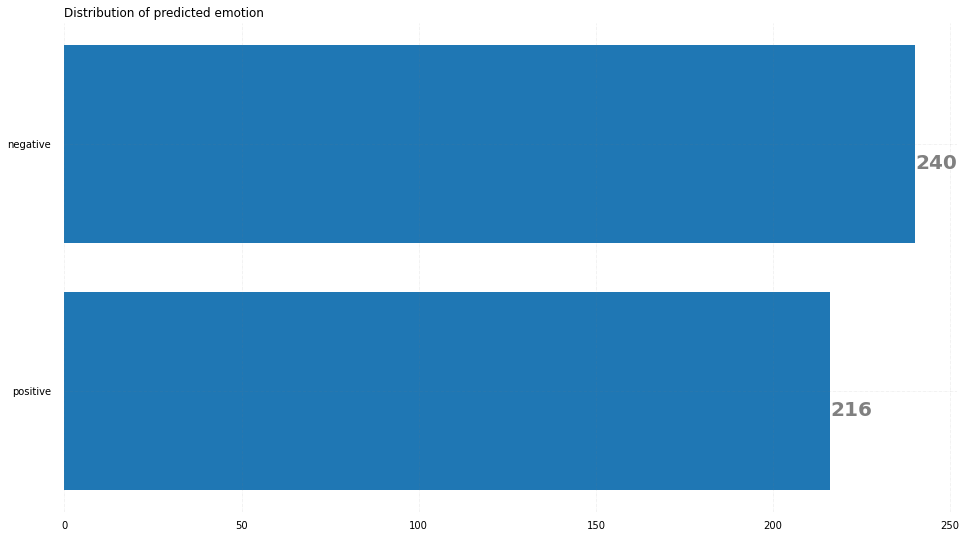

In [ ]:
plot_freq(sent_agg.index,sent_agg.values)

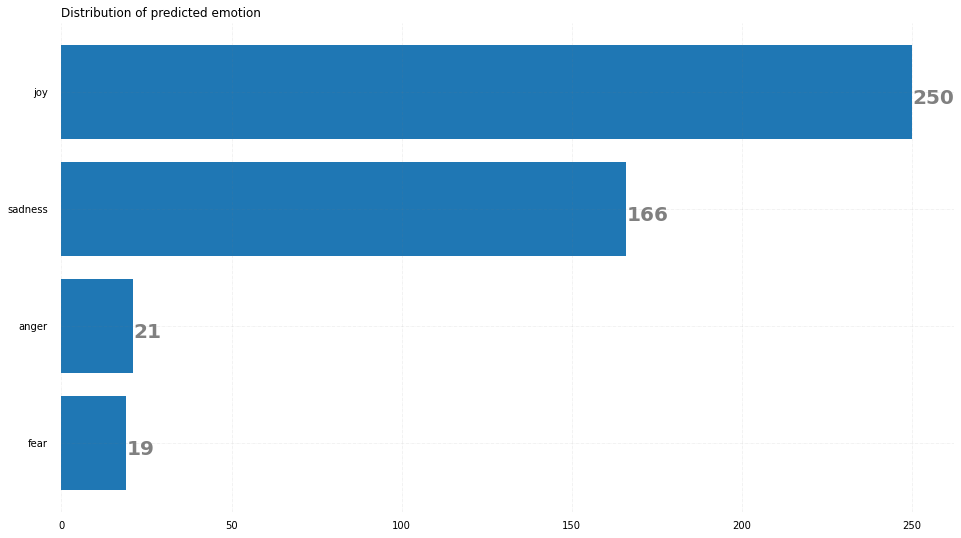

In [ ]:
plot_freq(emo_agg.index,emo_agg.values)

In [ ]:
distribution_emo_sent = letters_text_pred.groupby(['emotion_sentita','sentiment_sentita'],as_index=False).count().sort_values('text')
distribution_emo_sent

,emotion_sentita,sentiment_sentita,text,year,pred,pred_binary
1,fear,negative,19,19,19,19
0,anger,negative,21,21,21,21
5,sadness,positive,23,23,23,23
2,joy,negative,57,57,57,57
4,sadness,negative,143,143,143,143
3,joy,positive,193,193,193,193


In [ ]:
distribution_emo_sent = letters_text_pred.groupby(by=['emotion_sentita','sentiment_sentita']).size()

In [ ]:
distribution_emo_sent =distribution_emo_sent.reset_index()
distribution_emo_sent.index = distribution_emo_sent['emotion_sentita']+"-"+distribution_emo_sent['sentiment_sentita']

In [ ]:
distribution_emo_sent = distribution_emo_sent.reset_index()

In [ ]:
distribution_emo_sent['count'] = distribution_emo_sent[0]

In [ ]:
distribution_emo_sent = distribution_emo_sent.sort_values("count")

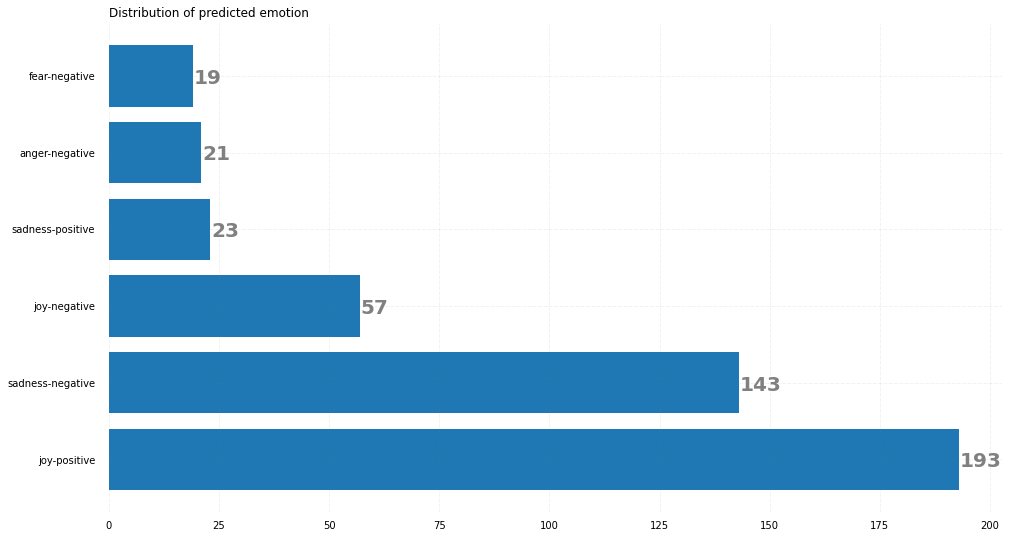

In [ ]:
plot_freq(distribution_emo_sent['emotion_sentita']+"-"+distribution_emo_sent['sentiment_sentita'],distribution_emo_sent['count'])

In [ ]:
letters_sent_year  = letters_text_pred.groupby(['year', 'sentiment_sentita'],as_index = False).agg('text').count()

In [ ]:
letters_sent_year

,year,sentiment_sentita,text
0,1888,negative,2
1,1888,positive,3
2,1889,negative,2
3,1889,positive,6
4,1890,negative,9
5,1890,positive,1
6,1891,negative,8
7,1891,positive,1
8,1892,negative,17
9,1892,positive,17


In [ ]:

def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = str(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, round(y_value)),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va,fontsize=15
            )                      # Vertically align label differently for
                                        # positive and negative values.


In [ ]:
def year_plot_sent(x,x2):
  barWidth = 0.25
  fig, ax = plt.subplots(figsize =(24, 9))

  pos = x#letters_sent_year[letters_sent_year['sentiment_sentita'] == 'positive']['text']
  neg = x2#letters_sent_year[letters_sent_year['sentiment_sentita'] == 'negative']['text']
  br1 = np.arange(len(neg))
  br2 = [x + barWidth for x in br1]
  #br3 = [x + barWidth for x in br2]
  t = plt.bar(br1, neg, color ='b', width = barWidth,
          edgecolor ='grey', label ='Negative')
  plt.bar(br2, pos, color ='r', width = barWidth,
          edgecolor ='grey', label ='Positive')

  #plt.bar(br3, CSE, color ='b', width = barWidth,
  #        edgecolor ='grey', label ='CSE')


  # Adding Xticks
  plt.xlabel('Year', fontweight ='bold', fontsize = 15)
  plt.ylabel('Number of negative/positive letters', fontweight ='bold', fontsize = 15)
  plt.xticks([r + barWidth for r in range(len(pos))],
          letters_sent_year.year.unique())



  # Call the function above. All the magic happens there.
  add_value_labels(ax)
  plt.legend()
  plt.show()

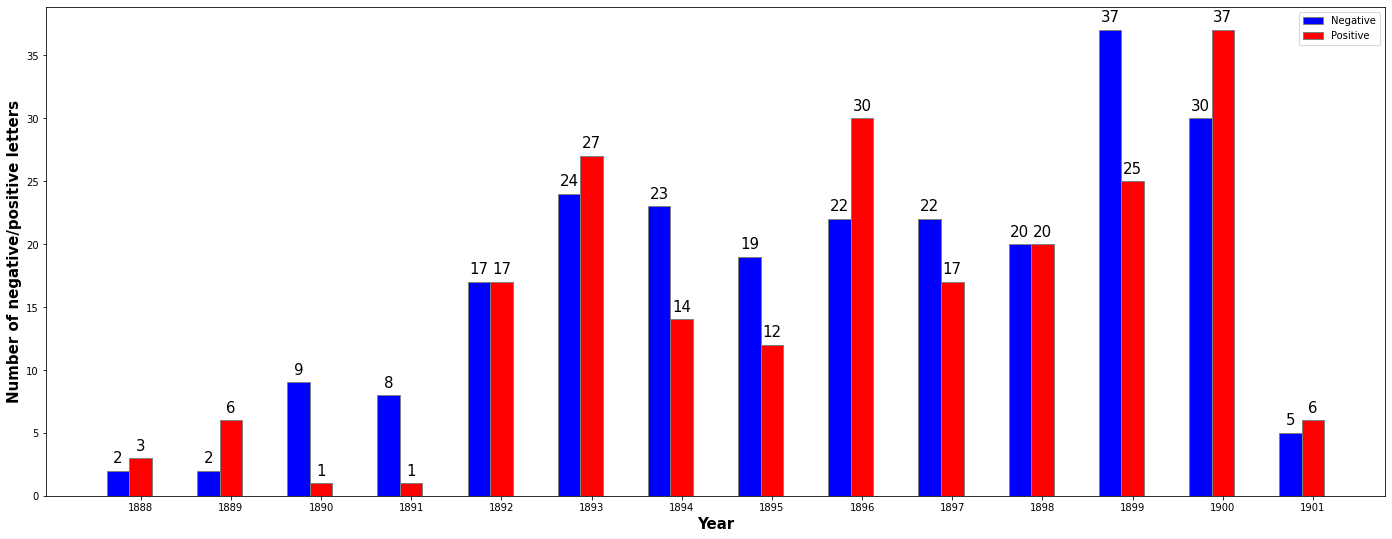

In [ ]:
x= letters_sent_year[letters_sent_year['sentiment_sentita'] == 'positive']['text']
x2 = letters_sent_year[letters_sent_year['sentiment_sentita'] == 'negative']['text']
year_plot(x = x, x2 = x2)

In [ ]:
letters_emo_year  = letters_text_pred.groupby(['year', 'emotion_sentita'],as_index = True).count().unstack(fill_value=0).stack()['text'].reset_index()

In [ ]:
letters_emo_year 

,year,emotion_sentita,text
0,1888,anger,0
1,1888,fear,0
2,1888,joy,3
3,1888,sadness,2
4,1889,anger,0
5,1889,fear,1
6,1889,joy,6
7,1889,sadness,1
8,1890,anger,0
9,1890,fear,0


In [ ]:
def year_plot_emo(x,x2,x3,x4, names = None):
  barWidth = 0.20
  fig, ax = plt.subplots(figsize =(24, 9))

  joy = x 
  fear = x2
  sadness = x3
  anger = x4

  if names is None:
    names = []
    names.append('Joy')
    names.append('Fear')
    names.append('Sadness')
    names.append('Anger')
  else:
    names = names
  br1 = np.arange(len(joy))
  br2 = [x + barWidth for x in br1]
  br3 = [x + barWidth for x in br2]
  br4 = [x + barWidth for x in br3]

  plt.bar(br1, joy, color ='yellow', width = barWidth,
          edgecolor ='grey', label =names[0])
  plt.bar(br2, fear, color ='gray', width = barWidth,
          edgecolor ='grey', label =names[1])
  plt.bar(br3, sadness, color ='b', width = barWidth,
          edgecolor ='grey', label =names[2])
  plt.bar(br4, anger, color ='r', width = barWidth,
        edgecolor ='grey', label =names[3])

  
  # Adding Xticks
  plt.xlabel('Year', fontweight ='bold', fontsize = 15)
  plt.ylabel('Number of {}/{}/{}/{} letters'.format(names[0],names[1],names[2],names[3]), fontweight ='bold', fontsize = 15)
  plt.xticks([r + barWidth for r in range(len(pos))],
          letters_sent_year.year.unique())
  # Call the function above. All the magic happens there.
  add_value_labels(ax)
  plt.legend()
  plt.show()

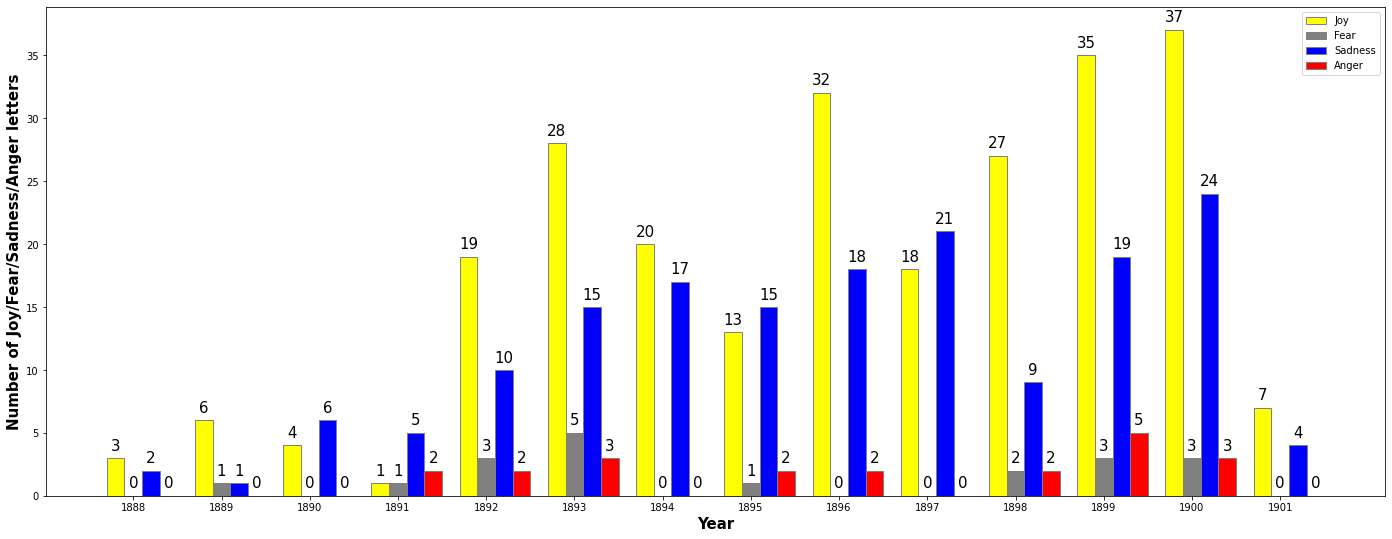

In [ ]:
x = letters_emo_year[letters_emo_year['emotion_sentita'] == 'joy']['text']
x2 = letters_emo_year[letters_emo_year['emotion_sentita'] == 'fear']['text']
x3 = letters_emo_year[letters_emo_year['emotion_sentita'] == 'sadness']['text']
x4 = letters_emo_year[letters_emo_year['emotion_sentita'] == 'anger']['text']
year_plot_emo(x,x2,x3,x4)

<hr>



<br>
<br>

# Neural Networks Model Results

<br>

In [ ]:
pred_sent_grouped[pred_sent_grouped.index == 'positive']

pred
positive    95
dtype: int64

In [ ]:
pred_sent_grouped =  letters_text_pred.groupby("pred").size()
pred_sent_grouped = pred_sent_grouped.sort_values(ascending=False)

In [ ]:
pred_sent_grouped

pred
negative    288
positive     95
neutral      70
both          3
dtype: int64

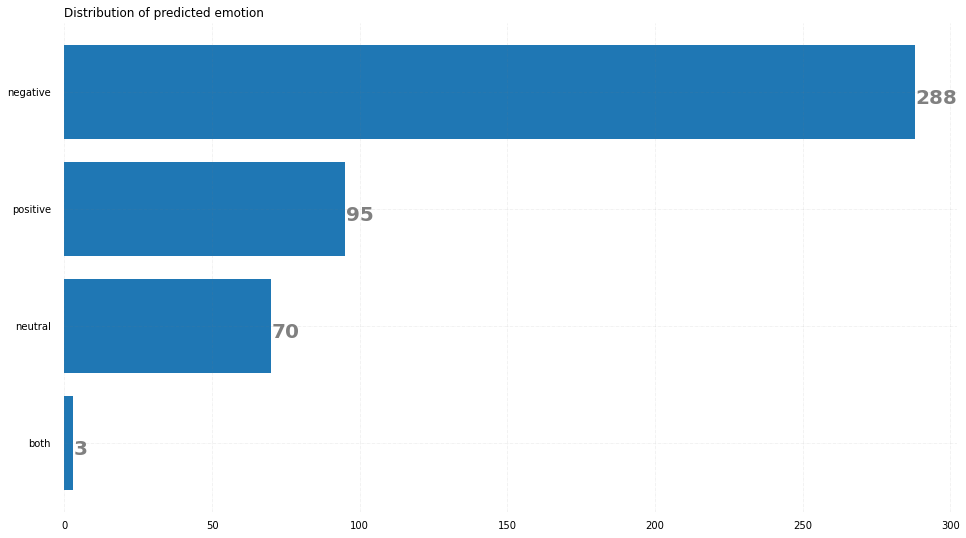

In [ ]:
plot_freq(pred_sent_grouped.index, pred_sent_grouped.values)

In [ ]:
pred_binary_sent_grouped = letters_text_pred.groupby("pred_binary").size()

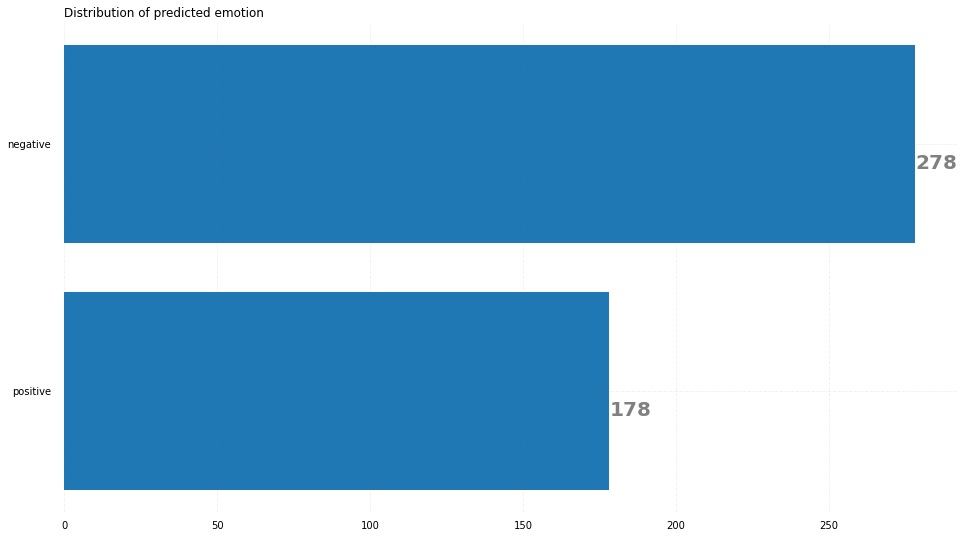

In [ ]:
plot_freq(pred_binary_sent_grouped.index, pred_binary_sent_grouped.values)

In [ ]:
letters_sent_year_binary  = letters_text_pred.groupby(['year', 'pred_binary'],as_index = False).agg('text').count()

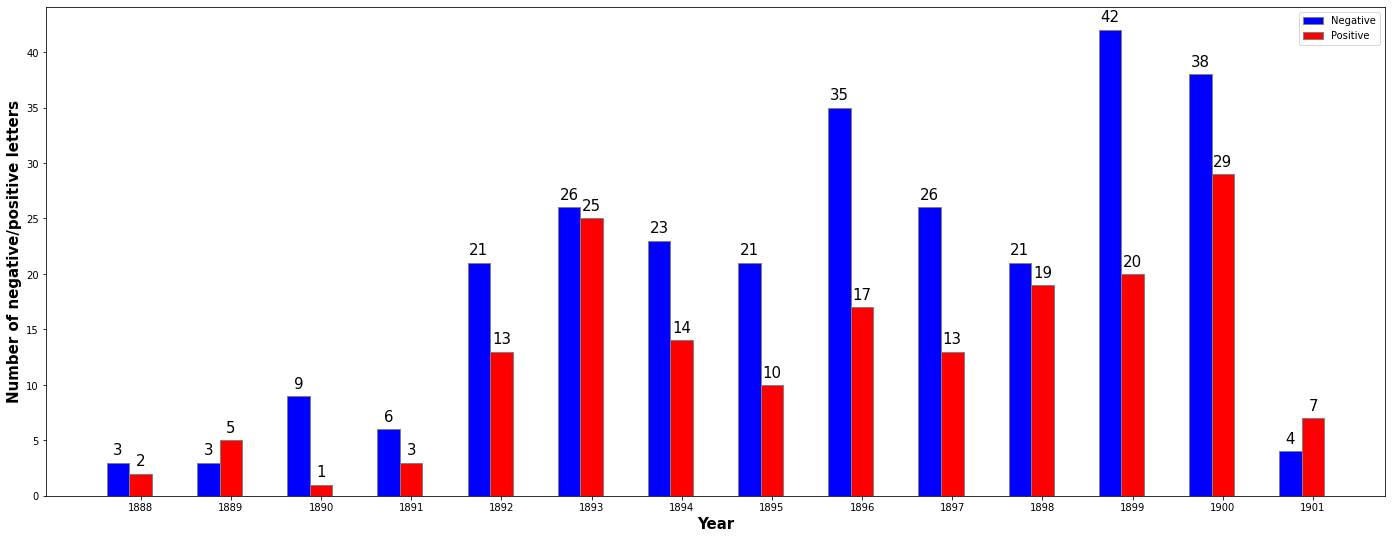

In [ ]:
x = letters_sent_year_binary[letters_sent_year_binary['pred_binary'] == 'positive']['text']
x2 = letters_sent_year_binary[letters_sent_year_binary['pred_binary'] == 'negative']['text']
year_plot(x = x, x2 = x2)

In [ ]:
letters_sent_pred  =  letters_text_pred.groupby(['year', 'pred'],as_index = True).count().unstack(fill_value=0).stack()['text'].reset_index()

In [ ]:
letters_sent_pred

,year,pred,text
0,1888,both,1
1,1888,negative,3
2,1888,neutral,0
3,1888,positive,1
4,1889,both,0
5,1889,negative,3
6,1889,neutral,3
7,1889,positive,2
8,1890,both,0
9,1890,negative,4


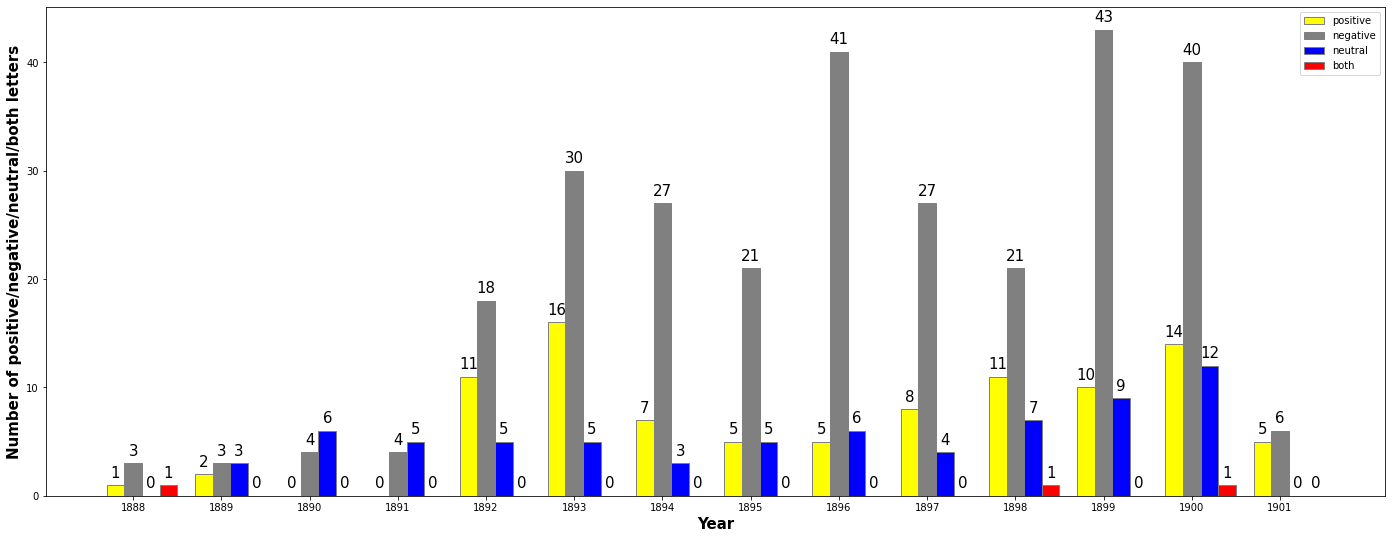

In [ ]:
x = letters_sent_pred[letters_sent_pred['pred'] == 'positive']['text']
x2 = letters_sent_pred[letters_sent_pred['pred'] == 'negative']['text']
x3 = letters_sent_pred[letters_sent_pred['pred'] == 'neutral']['text']
x4 = letters_sent_pred[letters_sent_pred['pred'] == 'both']['text']
year_plot_emo(x,x2,x3,x4, names = ['positive',"negative","neutral","both"])

<hr>



<br>
<br>

# Model comparison

<br>

In [ ]:
letters_text_pred

,text,year,pred,pred_binary,sentiment_sentita,emotion_sentita
CLET000002,\nRicordi editore per Puccini\nNapoli\nnon dub...,1888,positive,positive,positive,joy
CLET000024,\nMilano 11 Agosto\nSig.r Maestro G. Pucini\nC...,1888,negative,negative,negative,sadness
CLET000026,\n11 Sett\n \nCarissimo M° Puccini\nAlbergo Pi...,1888,both,negative,positive,joy
CLET000028,"\n16 7bre 8\nPreg.° S.° Maestro G. Puccini,...",1888,negative,positive,negative,sadness
CLET000029,\n2 Novembre 8\nPreg° Sig Maestro\nGiacomo P...,1888,negative,negative,positive,joy
...,...,...,...,...,...,...
CLET000782,\nPuccini.\nTorrelago.\nCasa Palermo avvisami ...,1901,negative,positive,negative,sadness
CLET000783,\n18 Marzo 1901\nIllustre Maestro\nComm.e G. P...,1901,positive,positive,negative,joy
CLET000784,\nMaestro Puccini\nTorre del Lago\nCome sa ten...,1901,positive,positive,positive,joy
CLET000785,\nMaestro Puccini\nTeatro Massimo. Palermo\nSo...,1901,positive,negative,positive,joy


In [ ]:
letters_text_pred[(letters_text_pred['pred_binary'] == "positive") & (letters_text_pred['sentiment_sentita'] == "positive")]

,text,year,pred,pred_binary,sentiment_sentita,emotion_sentita
CLET000002,\nRicordi editore per Puccini\nNapoli\nnon dub...,1888,positive,positive,positive,joy
CLET000039,\nMaestro Puccini\nAlbergo Posta. Reggio Emili...,1889,positive,positive,positive,joy
CLET000055,\n31 luglio 9\nPrego Sig Maestro\nGiacomo P...,1889,positive,positive,positive,sadness
CLET000062,"\n14 7bre 9\nCaris.o Puccini,\nUrgendoci aver...",1889,neutral,positive,positive,joy
CLET000063,\n25 7mbre 89\nCariss.o Puccini.\nRicevo la ...,1889,neutral,positive,positive,joy
...,...,...,...,...,...,...
CLET000768,\nPuccini.\nGrand Hôtel. Bruxelles.\nTito sarà...,1900,positive,positive,positive,joy
CLET000772,\nPuccini.\nTorrelago.\nBenissimo. Rievviva. S...,1900,positive,positive,positive,joy
CLET000776,"\n21 gennaio 1901\nCaro Giacomo,\nRoma\nTi uni...",1901,positive,positive,positive,joy
CLET000779,"\n10 Marzo 1\nCaro Puccini,\nRicevo la gr...",1901,negative,positive,positive,joy


In [ ]:
letters_text_pred[letters_text_pred['pred_binary'] != letters_text_pred['sentiment_sentita']]

,text,year,pred,pred_binary,sentiment_sentita,emotion_sentita
CLET000026,\n11 Sett\n \nCarissimo M° Puccini\nAlbergo Pi...,1888,both,negative,positive,joy
CLET000028,"\n16 7bre 8\nPreg.° S.° Maestro G. Puccini,...",1888,negative,positive,negative,sadness
CLET000029,\n2 Novembre 8\nPreg° Sig Maestro\nGiacomo P...,1888,negative,negative,positive,joy
CLET000053,\n18 Luglio 9\nCaris.o Puccini\nE l'indiri...,1889,neutral,negative,positive,joy
CLET000086,\nMilano 23 Ott. 90\r\nCariss.mo Puccini.\r\nI...,1890,negative,negative,positive,joy
...,...,...,...,...,...,...
CLET000781,\nGiacomo Puccini.\nTorrelago\nContento lei co...,1901,negative,negative,positive,joy
CLET000782,\nPuccini.\nTorrelago.\nCasa Palermo avvisami ...,1901,negative,positive,negative,sadness
CLET000783,\n18 Marzo 1901\nIllustre Maestro\nComm.e G. P...,1901,positive,positive,negative,joy
CLET000785,\nMaestro Puccini\nTeatro Massimo. Palermo\nSo...,1901,positive,negative,positive,joy


In [ ]:
letters_text_pred

,text,year,pred,pred_binary,sentiment_sentita,emotion_sentita
CLET000002,\nRicordi editore per Puccini\nNapoli\nnon dub...,1888,positive,positive,positive,joy
CLET000024,\nMilano 11 Agosto\nSig.r Maestro G. Pucini\nC...,1888,negative,negative,negative,sadness
CLET000026,\n11 Sett\n \nCarissimo M° Puccini\nAlbergo Pi...,1888,both,negative,positive,joy
CLET000028,"\n16 7bre 8\nPreg.° S.° Maestro G. Puccini,...",1888,negative,positive,negative,sadness
CLET000029,\n2 Novembre 8\nPreg° Sig Maestro\nGiacomo P...,1888,negative,negative,positive,joy
...,...,...,...,...,...,...
CLET000782,\nPuccini.\nTorrelago.\nCasa Palermo avvisami ...,1901,negative,positive,negative,sadness
CLET000783,\n18 Marzo 1901\nIllustre Maestro\nComm.e G. P...,1901,positive,positive,negative,joy
CLET000784,\nMaestro Puccini\nTorre del Lago\nCome sa ten...,1901,positive,positive,positive,joy
CLET000785,\nMaestro Puccini\nTeatro Massimo. Palermo\nSo...,1901,positive,negative,positive,joy


In [ ]:
notin = letters_text_pred[letters_text_pred['pred_binary'] != letters_text_pred['sentiment_sentita']]
notin

,text,year,pred,pred_binary,sentiment_sentita,emotion_sentita
CLET000026,\n11 Sett\n \nCarissimo M° Puccini\nAlbergo Pi...,1888,both,negative,positive,joy
CLET000028,"\n16 7bre 8\nPreg.° S.° Maestro G. Puccini,...",1888,negative,positive,negative,sadness
CLET000029,\n2 Novembre 8\nPreg° Sig Maestro\nGiacomo P...,1888,negative,negative,positive,joy
CLET000053,\n18 Luglio 9\nCaris.o Puccini\nE l'indiri...,1889,neutral,negative,positive,joy
CLET000086,\nMilano 23 Ott. 90\r\nCariss.mo Puccini.\r\nI...,1890,negative,negative,positive,joy
...,...,...,...,...,...,...
CLET000781,\nGiacomo Puccini.\nTorrelago\nContento lei co...,1901,negative,negative,positive,joy
CLET000782,\nPuccini.\nTorrelago.\nCasa Palermo avvisami ...,1901,negative,positive,negative,sadness
CLET000783,\n18 Marzo 1901\nIllustre Maestro\nComm.e G. P...,1901,positive,positive,negative,joy
CLET000785,\nMaestro Puccini\nTeatro Massimo. Palermo\nSo...,1901,positive,negative,positive,joy


<BarContainer object of 14 artists>

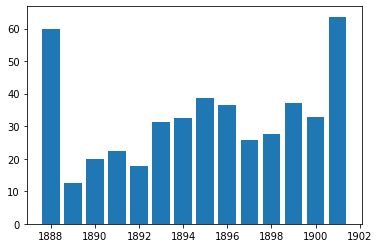

In [ ]:
plt.bar(notin.year.unique(), notin.groupby("year").size() / letters_df.groupby("year").size()*100)

In [ ]:
grouped = letters_text_pred.groupby(["pred_binary","sentiment_sentita"]).count()["text"]

In [ ]:
grouped = grouped.sort_values(ascending=False)
grouped

pred_binary  sentiment_sentita
negative     negative             186
positive     positive             124
negative     positive              92
positive     negative              54
Name: text, dtype: int64

In [ ]:
grouped.index = grouped.reset_index()["pred_binary"] +"_"+ grouped.reset_index()["sentiment_sentita"]

In [ ]:
grouped

negative_negative    186
positive_positive    124
negative_positive     92
positive_negative     54
Name: text, dtype: int64

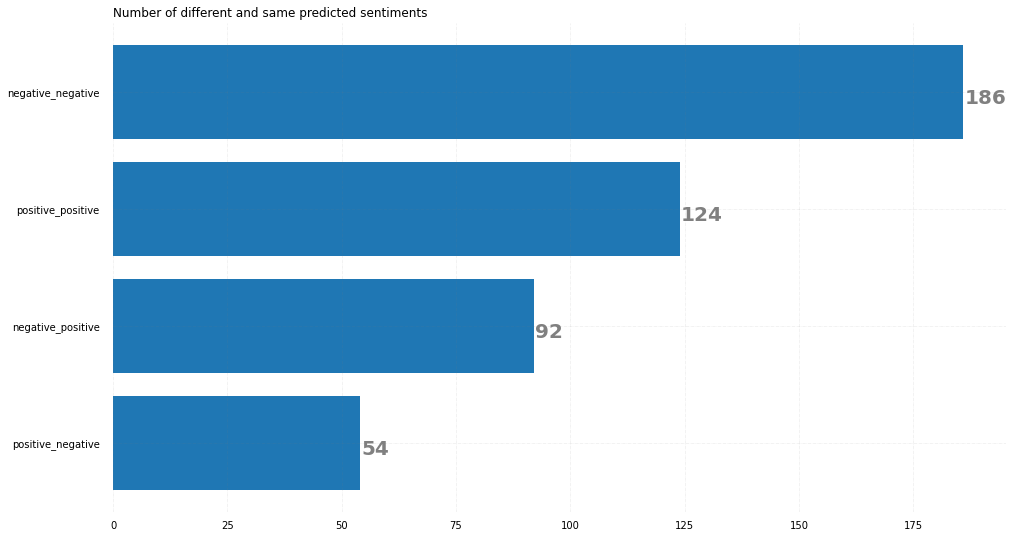

In [ ]:
plot_freq(grouped.index,grouped.values, title="Number of different and same predicted sentiments")

In [ ]:
grouped[grouped['sentiment_sentita'] == grouped['pred_binary']]

,pred_binary,sentiment_sentita,text,year,pred,emotion_sentita
0,negative,negative,186,186,186,186
3,positive,positive,124,124,124,124


In [ ]:
grouped[grouped['sentiment_sentita'] != grouped['pred_binary']]

,pred_binary,sentiment_sentita,text,year,pred,emotion_sentita
1,negative,positive,92,92,92,92
2,positive,negative,54,54,54,54


In [ ]:
pos = len(letters_text_pred[letters_text_pred['pred_binary'] == letters_text_pred['sentiment_sentita']])

In [ ]:
neg = len(letters_text_pred[letters_text_pred['pred_binary'] != letters_text_pred['sentiment_sentita']]

,text,year,pred,pred_binary,sentiment_sentita,emotion_sentita
CLET000026,\n11 Sett\n \nCarissimo M° Puccini\nAlbergo Pi...,1888,both,negative,positive,joy
CLET000028,"\n16 7bre 8\nPreg.° S.° Maestro G. Puccini,...",1888,negative,positive,negative,sadness
CLET000029,\n2 Novembre 8\nPreg° Sig Maestro\nGiacomo P...,1888,negative,negative,positive,joy
CLET000053,\n18 Luglio 9\nCaris.o Puccini\nE l'indiri...,1889,neutral,negative,positive,joy
CLET000086,\nMilano 23 Ott. 90\r\nCariss.mo Puccini.\r\nI...,1890,negative,negative,positive,joy
...,...,...,...,...,...,...
CLET000781,\nGiacomo Puccini.\nTorrelago\nContento lei co...,1901,negative,negative,positive,joy
CLET000782,\nPuccini.\nTorrelago.\nCasa Palermo avvisami ...,1901,negative,positive,negative,sadness
CLET000783,\n18 Marzo 1901\nIllustre Maestro\nComm.e G. P...,1901,positive,positive,negative,joy
CLET000785,\nMaestro Puccini\nTeatro Massimo. Palermo\nSo...,1901,positive,negative,positive,joy


In [4]:
letters_df =  pd.read_pickle('https://github.com/Andreaierardi/sentiment-puccini/blob/main/dataset/puccini_with_predictions.pkl?raw=true')

In [5]:
letters_df

,id,text,emit,rec,date,place,segnatura_volume,anno,volume,pag,nr_pag,named_people,named_works,named_places,named_teatri,tipologia,sottotipologia,scrittura,linuga,year,sentiment_sentita,emotion_sentita,pred,pred_binary
CLET000002,CLET000002,\nRicordi editore per Puccini\nNapoli\nnon dub...,Ricordi,Giacomo Puccini,1888-01-03,Milano,DOC00604,1887-1888,01,054,1,NaN,NaN,NaN,NaN,copialettere,telegramma,manoscritto,[italiano],1888,positive,joy,positive,positive
CLET000024,CLET000024,\nMilano 11 Agosto\nSig.r Maestro G. Pucini\nC...,Giulio Ricordi,Giacomo Puccini,1888-08-11,Milano,DOC00616,1888-1889,05,173,1,[Cesare Corti],NaN,NaN,NaN,copialettere,lettera,manoscritto,[italiano],1888,negative,sadness,negative,negative
CLET000026,CLET000026,\n11 Sett\n \nCarissimo M° Puccini\nAlbergo Pi...,Eugenio Tornaghi,Giacomo Puccini,1888-09-11,Milano,DOC00617,1888-1889,06,497,1,"[Franco Faccio, Giulio Ricordi]",[Edgar],NaN,NaN,copialettere,lettera,manoscritto,[italiano],1888,positive,joy,positive,negative
CLET000028,CLET000028,"\n16 7bre 8\nPreg.° S.° Maestro G. Puccini,...",Eugenio Tornaghi,Giacomo Puccini,1888-09-19,Milano,DOC00618,1888-1889,07,163,1,NaN,NaN,NaN,NaN,copialettere,lettera,manoscritto,[italiano],1888,negative,sadness,negative,negative
CLET000029,CLET000029,\n2 Novembre 8\nPreg° Sig Maestro\nGiacomo P...,Eugenio Tornaghi,Giacomo Puccini,1888-11-02,Milano,DOC00644,1889-1890,09,270,1,NaN,NaN,NaN,NaN,copialettere,lettera,manoscritto,[italiano],1888,positive,joy,negative,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CLET000782,CLET000782,\nPuccini.\nTorrelago.\nCasa Palermo avvisami ...,Ricordi,Giacomo Puccini,1901-03-15,Milano,DOC00870,1900-1901,17,104,1,[Augusto Lagan],[Tosca],NaN,NaN,copialettere,telegramma,manoscritto,[italiano],1888,negative,sadness,negative,positive
CLET000783,CLET000783,\n18 Marzo 1901\nIllustre Maestro\nComm.e G. P...,Ricordi,Giacomo Puccini,1901-03-18,Milano,DOC00870,1900-1901,17,248,1,[Elvira Puccini Bonturi],NaN,NaN,NaN,copialettere,lettera,manoscritto,[italiano],1888,negative,joy,positive,positive
CLET000784,CLET000784,\nMaestro Puccini\nTorre del Lago\nCome sa ten...,Ricordi,Giacomo Puccini,1901-03-19,Milano,DOC00870,1900-1901,17,279,1,[Cesare Corti],NaN,NaN,[Teatro Verdi],copialettere,telegramma,manoscritto,[italiano],1888,positive,joy,positive,positive
CLET000785,CLET000785,\nMaestro Puccini\nTeatro Massimo. Palermo\nSo...,Giulio Ricordi,Giacomo Puccini,1901-03-25,Milano,DOC00887,1901-1902,18,001,1,"[Leopoldo Mugnone, Elena Bianchini Cappelli, A...",[Tosca],NaN,"[Teatro Massimo, Teatro Verdi]",copialettere,telegramma,manoscritto,[italiano],1888,positive,joy,positive,positive


In [8]:
f = open("pred_comparison.txt","w")
for index, row in letters_df.iterrows():
    f.write("=======================|  "+"Letter ID: "+index+"  |=======================")
    f.write(row['text'])
    f.write("\n_______________________________\n\n")
    f.write("2-sentiment prediction: "+row['pred_binary']+"\n")
    f.write("SentITA sentiment prediction: "+row['sentiment_sentita']+"\n")
    f.write("4-sentiment prediction: "+ row['pred']+"\n")

    f.write("SentITA emotion detection: "+row['emotion_sentita']+"\n")

    f.write("\n_______________________________\n\n")


In [ ]:
#notequal = letters_df[letters_df['pred_binary'] != letters_df['sentiment_sentita']]

In [ ]:
#list(notequal.iterrows())[100][1]['text']

#import random
#
#check = dict()
#for i in range(50):
#  index = random.randrange(0,len(list(notequal.iterrows())))
#  lett = list(notequal.iterrows())[index][1]['text']
#  id = list(notequal.iterrows())[index][1]['id']
#  print(lett)
#  sent = input()
#  check[id] = sent
#  print("========================== FINE ========================== \n")
  #random.randrange(len(list(notequal.iterrows())))